# Privacy Protections in Anonymized Medical Records:
# A Comprehensive Study of Sensitive Diagnostic Attributes in MIMIC-IV

## Edward Tatchim, Sanjiv M. Narayan, Rohan Krishnamurty
## Datasci 233, Fall 2024, Session 1; v1.2, 2024: 12/09

### Project Goals
To study privacy guarantees of patients in MIMIC-IV, who presented to the Emergency room of Harvard Teaching Hospitals from 2008 to 2019. While this data is rigorously de-identified it includes ICD10 diagnostic codes, which may be considered sensitive attributes. The goal of this project is to quantify the risk of attribute or membership disclosure for various selected ICD10 codes using k-anonymity, L-diversity and t-closeness at baseline. We then intend to study how well the risk of disclosure and information gain could be mitigated by a series of generalization and data suppression techniques. We use rigorously de-identified real-world medical data in the form of MIMIC-IV released through MIT and Beth Israel Hospital, and will study ICD10 codes including but not limited to alcohol and substance abuse, in parallel with the DATASCI 233 coursework. This work is in preparation for submission to the Scientific sessions of the Heart Rhythm Society 2025.

### Data Use Permissions
To access data for our project, we turned to the Physionet resource (https://mimic.mit.edu/). All team members proceeded to complete specific training in human data handling, HIPAA and confidentiality. Each team member obtained a CITI certification to work on human data, which was submitted and formally approved by the Physionet organization (Harvard/Beth Israel Hospital; Massachussetts Institute of Technology) **prior to starting this project.** Certifications and approvals for each team member are available upon request. Only de-identified data will be shown during presentations and publications.

### Data Resource
MIMIC-IV is a publicly available de-identified database sourced from the electronic health records of the Harvard University/Beth Israel Deaconess Medical Center. For this study, we used a subset which contains ICD10 codes and subject demographics.
https://physionet.org/content/mimic-iv-ecg-ext-icd-labels/1.0.1/ Data available includes patient measurements, orders, diagnoses, procedures, treatments, and deidentified free-text clinical notes.  We use the core table that allows retrieval of different kinds of discharge diagnoses (as ICD-10-CM codes) for a given sample in MIMIV-IV-ECG. The initial scope of this project does not include processing of detailed clinical data (https://physionet.org/content/mimiciv/2.2/) or ECG waveforms (https://physionet.org/content/mimic-iv-ecg/1.0/), which would require more time than available for this project.

### De-identification process
"Patient identifiers as stipulated by HIPAA were removed. Patient identifiers were replaced using a random cipher, resulting in deidentified integer identifiers for patients, hospitalizations, and ICU stays. Structured data were filtered using look up tables and allow lists. If necessary, a free-text deidentification algorithm was applied to remove PHI from free-text. Finally, date and times were shifted randomly into the future using an offset measured in days. A single date shift was assigned to each subject_id. As a result, the data for a single patient are internally consistent. For example, if the time between two measures in the database was 4 hours in the raw data, then the calculated time difference in MIMIC-IV will also be 4 hours. Conversely, distinct patients are not temporally comparable. That is, two patients admitted in 2130 were not necessarily admitted in the same year."

### References
1. Strodthoff, N., Lopez Alcaraz, J. M., & Haverkamp, W. (2024). MIMIC-IV-ECG-Ext-ICD: Diagnostic labels for MIMIC-IV-ECG (version 1.0.1). PhysioNet. https://doi.org/10.13026/ypt5-9d58.
2. Strodthoff, N. Alcaraz, J.M.L., & Haverkamp, W. (2024). Prospects for Artificial Intelligence-Enhanced ECG as a Unified Screening Tool for Cardiac and Non-Cardiac Conditions – An Explorative Study in Emergency Care, European Heart Journal - Digital Health, ztae039.
3. Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

## Data Dictionary - see Appendix

This is an extensive data repository as summarized in this link: https://physionet.org/content/mimiciv/2.2/  

## Code - Imports, Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown
from scipy.stats import wasserstein_distance
import ast
#code from Lab 2, DATASCI 233
def safe_print_err(e, locals=locals(), globals=globals()):
    locals = locals or {}
    globals = globals or {}
    __problem = eval('__problem', locals, globals)
    err_msg = str(e)
    if type(e) in (NameError, KeyError):
        var_name_split = str(e).split("'")
        if len(var_name_split) > 1:
            var_name = var_name_split[1]
            err_msg = f"'{var_name}' is not defined."

    display(Markdown(f"<div class='alert alert-block alert-danger'><b>Error in problem {__problem}</b>: {err_msg}</div>"))

def print_mk(msg):
    display(Markdown(msg))

In [2]:
df_long = pd.read_csv("records_w_diag_icd10.csv")
#df_long.head()
df_long.head()

,file_name,study_id,subject_id,ecg_time,ed_stay_id,ed_hadm_id,hosp_hadm_id,ed_diag_ed,ed_diag_hosp,hosp_diag_hosp,...,age,anchor_year,anchor_age,dod,ecg_no_within_stay,ecg_taken_in_ed,ecg_taken_in_hosp,ecg_taken_in_ed_or_hosp,fold,strat_fold
0,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,40689238,10000032,2180-07-23 08:44:00,39399961.0,29079034.0,NaN,"['R4182', 'G9340']","['F319', 'J449', 'B182', 'E871', 'V462', 'I958...",[],...,52.0,2180.0,52.0,2180-09-09,0,True,False,True,17,9
1,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,44458630,10000032,2180-07-23 09:54:00,39399961.0,29079034.0,NaN,"['R4182', 'G9340']","['F319', 'J449', 'B182', 'E871', 'V462', 'I958...",[],...,52.0,2180.0,52.0,2180-09-09,1,True,False,True,17,9
2,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,49036311,10000032,2180-08-06 09:07:00,NaN,NaN,25742920.0,[],[],"['J449', 'B182', 'E871', 'R197', 'V462', 'R188...",...,52.0,2180.0,52.0,2180-09-09,0,False,True,True,17,9
3,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,45090959,10000117,2181-03-04 17:14:00,NaN,NaN,NaN,[],[],[],...,55.0,2174.0,48.0,NaN,-1,False,False,False,18,0
4,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,48446569,10000117,2183-09-18 13:52:00,33176849.0,27988844.0,NaN,"['S72092A', 'W1830XA']","['K219', 'F419', 'Z7901', 'Z87891', 'G43909', ...",[],...,57.0,2174.0,48.0,NaN,0,True,False,True,18,0


In [3]:
df = df_long.drop(['file_name', 'study_id', 'anchor_year', 'anchor_age', 'fold', 'strat_fold', 'ed_stay_id', 'ed_hadm_id', 'hosp_hadm_id'], axis = 1)
df.head()

,subject_id,ecg_time,ed_diag_ed,ed_diag_hosp,hosp_diag_hosp,all_diag_hosp,all_diag_all,gender,age,dod,ecg_no_within_stay,ecg_taken_in_ed,ecg_taken_in_hosp,ecg_taken_in_ed_or_hosp
0,10000032,2180-07-23 08:44:00,"['R4182', 'G9340']","['F319', 'J449', 'B182', 'E871', 'V462', 'I958...",[],"['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...","['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...",F,52.0,2180-09-09,0,True,False,True
1,10000032,2180-07-23 09:54:00,"['R4182', 'G9340']","['F319', 'J449', 'B182', 'E871', 'V462', 'I958...",[],"['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...","['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...",F,52.0,2180-09-09,1,True,False,True
2,10000032,2180-08-06 09:07:00,[],[],"['J449', 'B182', 'E871', 'R197', 'V462', 'R188...","['K7469', 'E871', 'E875', 'R197', 'J449', 'R18...","['K7469', 'E871', 'E875', 'R197', 'J449', 'R18...",F,52.0,2180-09-09,0,False,True,True
3,10000117,2181-03-04 17:14:00,[],[],[],[],[],F,55.0,NaN,-1,False,False,False
4,10000117,2183-09-18 13:52:00,"['S72092A', 'W1830XA']","['K219', 'F419', 'Z7901', 'Z87891', 'G43909', ...",[],"['E7800', 'K219', 'Z87442', 'S72012A', 'I341',...","['E7800', 'K219', 'Z87442', 'S72012A', 'I341',...",F,57.0,NaN,0,True,False,True


In [4]:
import pandas as pd
import ast

# Define the clean_column function
def clean_column(val):
    if pd.isna(val) or val is None:
        return None
    try:
        # Safely evaluate the string and remove empty lists
        evaluated = ast.literal_eval(val)
        if isinstance(evaluated, tuple):
            # Filter out empty lists
            return tuple(item for item in evaluated if item != [])
        return evaluated
    except (ValueError, SyntaxError):
        return val

# Groupby and apply aggregations
df = df.groupby('subject_id').agg({
    'ecg_time': 'first',
    'ed_diag_ed': lambda x: ','.join(map(str, filter(lambda item: clean_column(item) != [], x))),
    'ed_diag_hosp': lambda x: ','.join(map(str, filter(lambda item: clean_column(item) != [], x))),
    'hosp_diag_hosp': lambda x: ','.join(map(str, filter(lambda item: clean_column(item) != [], x))),
    'all_diag_hosp': lambda x: ','.join(map(str, filter(lambda item: clean_column(item) != [], x))),
    'all_diag_all': lambda x: ','.join(map(str, filter(lambda item: clean_column(item) != [], x))),
    'gender': 'first',
    'age': 'first',
    'dod': 'first',
    'ecg_no_within_stay': lambda x: x[x >= 0].sum(),
    'ecg_taken_in_ed': lambda x: any(x),
    'ecg_taken_in_hosp': lambda x: any(x),
    'ecg_taken_in_ed_or_hosp': lambda x: any(x),
}).reset_index()

df.head()


,subject_id,ecg_time,ed_diag_ed,ed_diag_hosp,hosp_diag_hosp,all_diag_hosp,all_diag_all,gender,age,dod,ecg_no_within_stay,ecg_taken_in_ed,ecg_taken_in_hosp,ecg_taken_in_ed_or_hosp
0,10000032,2180-07-23 08:44:00,"['R4182', 'G9340'],['R4182', 'G9340']","['F319', 'J449', 'B182', 'E871', 'V462', 'I958...","['J449', 'B182', 'E871', 'R197', 'V462', 'R188...","['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...","['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...",F,52.0,2180-09-09,1,True,True,True
1,10000117,2181-03-04 17:14:00,"['S72092A', 'W1830XA']","['K219', 'F419', 'Z7901', 'Z87891', 'G43909', ...",,"['E7800', 'K219', 'Z87442', 'S72012A', 'I341',...","['E7800', 'K219', 'Z87442', 'S72012A', 'I341',...",F,55.0,None,0,True,False,True
2,10000285,2159-11-26 14:29:00,['R1012'],,,,['R1012'],M,34.0,None,0,True,False,True
3,10000560,2189-10-03 12:54:00,,,,,,F,53.0,None,0,False,False,False
4,10000635,2136-06-19 07:24:00,"['E119', 'R42', 'I10', 'E780']",,"['E119', 'R001', 'I10']","['R001', 'I10', 'E119']","['R001', 'I10', 'E119'],['E119', 'R42', 'I10',...",F,74.0,None,0,True,True,True


In [5]:
# Function k_anon can test different k-anonymity guarantees

def k_anon (dataset, qID):
    #qIDs: quasi-identifiers
    subset_df = dataset[qID]

    # Drop duplicate rows based on the quasi-identifiers
    #eqv_classes = subset_df.drop_duplicates().reset_index(drop=True)

    # Group the original data by quasi-identifiers and count the number of rows in each group
    eqv_classes = dataset.groupby(qID).size().reset_index(name='k')

    # Calculate the best k-anonymity guarantee, which is the minimum value of 'k' across all equivalence classes
    k_min = eqv_classes['k'].min()

    try:
        print_mk(f"There are ${len(eqv_classes)}$ equivalence classes:")
        display(eqv_classes)
        print_mk(f"The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k={k_min}.$")
    except Exception as e:
        safe_print_err(e)

    return k_min, eqv_classes

## Exploring Equivalence Classes and k-Anonymity

### 'file_name' is unique between records (k=1), and 'ecg_no_within_stay' has outliers that also produce k=1

In [6]:
qID = ['file_name', 'all_diag_all', 'gender', 'age', 'ecg_no_within_stay']
k_anon(df_long, qID)

There are $795546$ equivalence classes:

,file_name,all_diag_all,gender,age,ecg_no_within_stay,k
0,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,"['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...",F,52.0,0,1
1,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,"['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...",F,52.0,1,1
2,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,"['K7469', 'E871', 'E875', 'R197', 'J449', 'R18...",F,52.0,0,1
3,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,[],F,55.0,-1,1
4,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,"['E7800', 'K219', 'Z87442', 'S72012A', 'I341',...",F,57.0,0,1
...,...,...,...,...,...,...
795541,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,"['J9690', 'E785', 'I69952', 'J690', 'G40301', ...",M,58.0,0,1
795542,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,"['J9690', 'E785', 'I69952', 'J690', 'G40301', ...",M,58.0,1,1
795543,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,"['H53469', 'R569', 'N390', 'E039', 'I619', 'I2...",F,57.0,0,1
795544,mimic-iv-ecg-diagnostic-electrocardiogram-matc...,"['H53469', 'R569', 'N390', 'E039', 'I619', 'I2...",F,57.0,0,1


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

(1,
                                                 file_name  \
 0       mimic-iv-ecg-diagnostic-electrocardiogram-matc...   
 1       mimic-iv-ecg-diagnostic-electrocardiogram-matc...   
 2       mimic-iv-ecg-diagnostic-electrocardiogram-matc...   
 3       mimic-iv-ecg-diagnostic-electrocardiogram-matc...   
 4       mimic-iv-ecg-diagnostic-electrocardiogram-matc...   
 ...                                                   ...   
 795541  mimic-iv-ecg-diagnostic-electrocardiogram-matc...   
 795542  mimic-iv-ecg-diagnostic-electrocardiogram-matc...   
 795543  mimic-iv-ecg-diagnostic-electrocardiogram-matc...   
 795544  mimic-iv-ecg-diagnostic-electrocardiogram-matc...   
 795545  mimic-iv-ecg-diagnostic-electrocardiogram-matc...   
 
                                              all_diag_all gender   age  \
 0       ['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...      F  52.0   
 1       ['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...      F  52.0   
 2       ['K7469', 'E871'

## All diagnoses, gender, age, ecg_no_within_stay gives k=1

In [7]:
qID = ['all_diag_all', 'gender', 'age', 'ecg_no_within_stay']
k_anon(df, qID)

There are $119051$ equivalence classes:

,all_diag_all,gender,age,ecg_no_within_stay,k
0,,F,16.0,0,2
1,,F,17.0,0,11
2,,F,18.0,0,114
3,,F,19.0,0,246
4,,F,20.0,0,338
...,...,...,...,...,...
119046,"['Z98890', 'R079', 'I10']",M,63.0,0,1
119047,"['Z98890', 'R1032', 'E860', 'C259'],['R627', '...",M,70.0,0,1
119048,"['Z98890', 'R109', 'K7469', 'E119'],['R112', '...",M,55.0,0,1
119049,"['Z98890', 'R42', 'I10'],['Z98890', 'R42', 'I10']",M,76.0,1,1


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

(1,
                                              all_diag_all gender   age  \
 0                                                              F  16.0   
 1                                                              F  17.0   
 2                                                              F  18.0   
 3                                                              F  19.0   
 4                                                              F  20.0   
 ...                                                   ...    ...   ...   
 119046                          ['Z98890', 'R079', 'I10']      M  63.0   
 119047  ['Z98890', 'R1032', 'E860', 'C259'],['R627', '...      M  70.0   
 119048  ['Z98890', 'R109', 'K7469', 'E119'],['R112', '...      M  55.0   
 119049  ['Z98890', 'R42', 'I10'],['Z98890', 'R42', 'I10']      M  76.0   
 119050  ['Z9981', 'Z87891', 'J449', 'J189'],['Z9981', ...      F  58.0   
 
         ecg_no_within_stay    k  
 0                        0    2  
 1                      

## All diagnoses, gender, ecg_no_within_stay gives k=1

In [8]:
qID = ['all_diag_all', 'gender', 'ecg_no_within_stay']
k_anon(df, qID)

There are $111361$ equivalence classes:

,all_diag_all,gender,ecg_no_within_stay,k
0,,F,0,20247
1,,F,1,5
2,,F,6,1
3,,F,15,1
4,,M,0,15422
...,...,...,...,...
111356,"['Z98890', 'R079', 'I10']",M,0,1
111357,"['Z98890', 'R1032', 'E860', 'C259'],['R627', '...",M,0,1
111358,"['Z98890', 'R109', 'K7469', 'E119'],['R112', '...",M,0,1
111359,"['Z98890', 'R42', 'I10'],['Z98890', 'R42', 'I10']",M,1,1


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

(1,
                                              all_diag_all gender  \
 0                                                              F   
 1                                                              F   
 2                                                              F   
 3                                                              F   
 4                                                              M   
 ...                                                   ...    ...   
 111356                          ['Z98890', 'R079', 'I10']      M   
 111357  ['Z98890', 'R1032', 'E860', 'C259'],['R627', '...      M   
 111358  ['Z98890', 'R109', 'K7469', 'E119'],['R112', '...      M   
 111359  ['Z98890', 'R42', 'I10'],['Z98890', 'R42', 'I10']      M   
 111360  ['Z9981', 'Z87891', 'J449', 'J189'],['Z9981', ...      F   
 
         ecg_no_within_stay      k  
 0                        0  20247  
 1                        1      5  
 2                        6      1  
 3                

## All diagnoses, gender, age gives k=1

In [9]:
qID = ['all_diag_all', 'gender', 'age']
k_anon(df, qID)

There are $118907$ equivalence classes:

,all_diag_all,gender,age,k
0,,F,16.0,2
1,,F,17.0,11
2,,F,18.0,114
3,,F,19.0,246
4,,F,20.0,338
...,...,...,...,...
118902,"['Z98890', 'R079', 'I10']",M,63.0,1
118903,"['Z98890', 'R1032', 'E860', 'C259'],['R627', '...",M,70.0,1
118904,"['Z98890', 'R109', 'K7469', 'E119'],['R112', '...",M,55.0,1
118905,"['Z98890', 'R42', 'I10'],['Z98890', 'R42', 'I10']",M,76.0,1


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

(1,
                                              all_diag_all gender   age    k
 0                                                              F  16.0    2
 1                                                              F  17.0   11
 2                                                              F  18.0  114
 3                                                              F  19.0  246
 4                                                              F  20.0  338
 ...                                                   ...    ...   ...  ...
 118902                          ['Z98890', 'R079', 'I10']      M  63.0    1
 118903  ['Z98890', 'R1032', 'E860', 'C259'],['R627', '...      M  70.0    1
 118904  ['Z98890', 'R109', 'K7469', 'E119'],['R112', '...      M  55.0    1
 118905  ['Z98890', 'R42', 'I10'],['Z98890', 'R42', 'I10']      M  76.0    1
 118906  ['Z9981', 'Z87891', 'J449', 'J189'],['Z9981', ...      F  58.0    1
 
 [118907 rows x 4 columns])

## All diagnoses, gender gives k=1

In [10]:
qID = ['all_diag_all', 'gender']
k_anon(df, qID)

There are $111199$ equivalence classes:

,all_diag_all,gender,k
0,,F,20254
1,,M,15423
2,,missing,1744
3,"['A021', 'E860', 'F329', 'E785', 'I10', 'K219'...",M,1
4,"['A021', 'E871', 'A048', 'D649', 'K219', 'K510...",M,1
...,...,...,...
111194,"['Z98890', 'R079', 'I10']",M,1
111195,"['Z98890', 'R1032', 'E860', 'C259'],['R627', '...",M,1
111196,"['Z98890', 'R109', 'K7469', 'E119'],['R112', '...",M,1
111197,"['Z98890', 'R42', 'I10'],['Z98890', 'R42', 'I10']",M,1


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

(1,
                                              all_diag_all   gender      k
 0                                                                F  20254
 1                                                                M  15423
 2                                                          missing   1744
 3       ['A021', 'E860', 'F329', 'E785', 'I10', 'K219'...        M      1
 4       ['A021', 'E871', 'A048', 'D649', 'K219', 'K510...        M      1
 ...                                                   ...      ...    ...
 111194                          ['Z98890', 'R079', 'I10']        M      1
 111195  ['Z98890', 'R1032', 'E860', 'C259'],['R627', '...        M      1
 111196  ['Z98890', 'R109', 'K7469', 'E119'],['R112', '...        M      1
 111197  ['Z98890', 'R42', 'I10'],['Z98890', 'R42', 'I10']        M      1
 111198  ['Z9981', 'Z87891', 'J449', 'J189'],['Z9981', ...        F      1
 
 [111199 rows x 3 columns])

## High k-anonymity from 'ecg_taken_in_hosp', 'ecg_taken_in_ed', 'gender'

In [11]:
qID = ['ecg_taken_in_hosp']
k_anon(df, qID)

There are $2$ equivalence classes:

,ecg_taken_in_hosp,k
0,False,79171
1,True,82181


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=79171.$

(79171,
    ecg_taken_in_hosp      k
 0              False  79171
 1               True  82181)

In [12]:
qID = ['ecg_taken_in_ed']
k_anon(df, qID)

There are $2$ equivalence classes:

,ecg_taken_in_ed,k
0,False,77608
1,True,83744


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=77608.$

(77608,
    ecg_taken_in_ed      k
 0            False  77608
 1             True  83744)

In [13]:
qID = ['gender']
k_anon(df, qID)

There are $3$ equivalence classes:

,gender,k
0,F,83597
1,M,76011
2,missing,1744


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1744.$

(1744,
     gender      k
 0        F  83597
 1        M  76011
 2  missing   1744)

### **Note**, age provides a k = 1, but generalizing this greatly increases generalizability
### Note that there are outliers in age (k=1), who can be readily identified!  This is something to explore, and is a potential weakness of even this 'de-identified data'.

In [14]:
qID = ['age']
k_anon(df, qID)

There are $86$ equivalence classes:

,age,k
0,12.0,1
1,14.0,4
2,15.0,3
3,16.0,9
4,17.0,23
...,...,...
81,94.0,37
82,95.0,14
83,96.0,4
84,97.0,4


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

(1,
      age   k
 0   12.0   1
 1   14.0   4
 2   15.0   3
 3   16.0   9
 4   17.0  23
 ..   ...  ..
 81  94.0  37
 82  95.0  14
 83  96.0   4
 84  97.0   4
 85  98.0   3
 
 [86 rows x 2 columns])

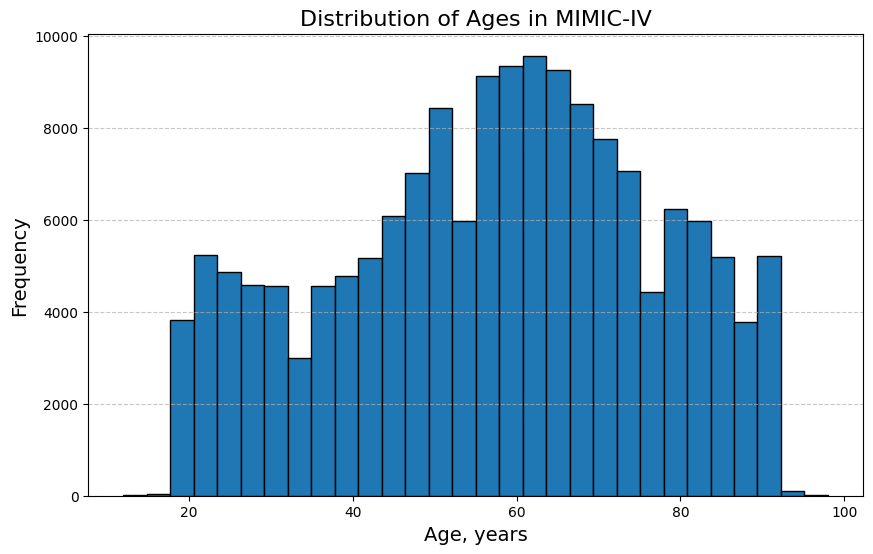

In [15]:
#df_fm['lecg_no_within_stay'] = np.log(df_fm['ecg_no_within_stay']+2)

#plot age histogram
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=30, edgecolor='black')
plt.title('Distribution of Ages in MIMIC-IV', fontsize=16)
plt.xlabel('Age, years', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [16]:
# Generalizing age numbers by binning
df_binnedage = df
df_binnedage['binned_age'] = df['age'].apply(lambda x:
           20 if 0 <= x < 30 else
           30 if 30 <= x < 40 else
           40 if 40 <= x < 50 else
           50 if 50 <= x < 60 else
           60 if 60 <= x < 70 else
           70 if 70 <= x < 80 else
           80 if 80 <= x < 90 else
           90 if x > 90
           else x
)
df_binnedage['binned_age'].value_counts()

binned_age
60.0    30420
50.0    29761
70.0    23414
40.0    19898
20.0    18542
80.0    16988
30.0    15257
90.0     5328
Name: count, dtype: int64

In [17]:
qID = ['binned_age']
k_anon(df_binnedage, qID)

There are $8$ equivalence classes:

,binned_age,k
0,20.0,18542
1,30.0,15257
2,40.0,19898
3,50.0,29761
4,60.0,30420
5,70.0,23414
6,80.0,16988
7,90.0,5328


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=5328.$

(5328,
    binned_age      k
 0        20.0  18542
 1        30.0  15257
 2        40.0  19898
 3        50.0  29761
 4        60.0  30420
 5        70.0  23414
 6        80.0  16988
 7        90.0   5328)

## All diagnoses, gender, 'ecg_no_within_stay' provide k = 1
## This can lead to automatic attribute/membership disclosure....  WE will explore this more with t-closeness and so on.

In [18]:
qID = ['ecg_no_within_stay']
k_anon(df, qID)

There are $309$ equivalence classes:

,ecg_no_within_stay,k
0,0,110142
1,1,21036
2,2,2814
3,3,7509
4,4,2045
...,...,...
304,853,1
305,861,1
306,871,1
307,2016,1


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

(1,
      ecg_no_within_stay       k
 0                     0  110142
 1                     1   21036
 2                     2    2814
 3                     3    7509
 4                     4    2045
 ..                  ...     ...
 304                 853       1
 305                 861       1
 306                 871       1
 307                2016       1
 308                5565       1
 
 [309 rows x 2 columns])

In [19]:
qID = ['all_diag_all', 'gender', 'ecg_no_within_stay']
k_anon(df, qID)

There are $111361$ equivalence classes:

,all_diag_all,gender,ecg_no_within_stay,k
0,,F,0,20247
1,,F,1,5
2,,F,6,1
3,,F,15,1
4,,M,0,15422
...,...,...,...,...
111356,"['Z98890', 'R079', 'I10']",M,0,1
111357,"['Z98890', 'R1032', 'E860', 'C259'],['R627', '...",M,0,1
111358,"['Z98890', 'R109', 'K7469', 'E119'],['R112', '...",M,0,1
111359,"['Z98890', 'R42', 'I10'],['Z98890', 'R42', 'I10']",M,1,1


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

(1,
                                              all_diag_all gender  \
 0                                                              F   
 1                                                              F   
 2                                                              F   
 3                                                              F   
 4                                                              M   
 ...                                                   ...    ...   
 111356                          ['Z98890', 'R079', 'I10']      M   
 111357  ['Z98890', 'R1032', 'E860', 'C259'],['R627', '...      M   
 111358  ['Z98890', 'R109', 'K7469', 'E119'],['R112', '...      M   
 111359  ['Z98890', 'R42', 'I10'],['Z98890', 'R42', 'I10']      M   
 111360  ['Z9981', 'Z87891', 'J449', 'J189'],['Z9981', ...      F   
 
         ecg_no_within_stay      k  
 0                        0  20247  
 1                        1      5  
 2                        6      1  
 3                

In [20]:
qID = ['gender', 'ecg_no_within_stay']
k_anon(df, qID)

There are $483$ equivalence classes:

,gender,ecg_no_within_stay,k
0,F,0,59782
1,F,1,10432
2,F,2,1401
3,F,3,3353
4,F,4,942
...,...,...,...
478,M,853,1
479,M,861,1
480,M,2016,1
481,M,5565,1


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

(1,
       gender  ecg_no_within_stay      k
 0          F                   0  59782
 1          F                   1  10432
 2          F                   2   1401
 3          F                   3   3353
 4          F                   4    942
 ..       ...                 ...    ...
 478        M                 853      1
 479        M                 861      1
 480        M                2016      1
 481        M                5565      1
 482  missing                   0   1744
 
 [483 rows x 3 columns])

### **Note**: Improve generalizability by removing 'missing' gender (sex), and generalize 'ecg_no_within_stay' to bin outliers

In [21]:
df_fm = df[df["gender"] != "missing"]
df_fm['gender'].value_counts()

gender
F    83597
M    76011
Name: count, dtype: int64

In [22]:
qID = ['gender', 'ecg_no_within_stay']
k_anon(df_fm, qID)

There are $482$ equivalence classes:

,gender,ecg_no_within_stay,k
0,F,0,59782
1,F,1,10432
2,F,2,1401
3,F,3,3353
4,F,4,942
...,...,...,...
477,M,827,1
478,M,853,1
479,M,861,1
480,M,2016,1


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

(1,
     gender  ecg_no_within_stay      k
 0        F                   0  59782
 1        F                   1  10432
 2        F                   2   1401
 3        F                   3   3353
 4        F                   4    942
 ..     ...                 ...    ...
 477      M                 827      1
 478      M                 853      1
 479      M                 861      1
 480      M                2016      1
 481      M                5565      1
 
 [482 rows x 3 columns])

In [23]:
qID = ['ecg_no_within_stay']
k_anon(df_fm, qID)

There are $309$ equivalence classes:

,ecg_no_within_stay,k
0,0,108398
1,1,21036
2,2,2814
3,3,7509
4,4,2045
...,...,...
304,853,1
305,861,1
306,871,1
307,2016,1


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

(1,
      ecg_no_within_stay       k
 0                     0  108398
 1                     1   21036
 2                     2    2814
 3                     3    7509
 4                     4    2045
 ..                  ...     ...
 304                 853       1
 305                 861       1
 306                 871       1
 307                2016       1
 308                5565       1
 
 [309 rows x 2 columns])

In [24]:
df_fm['ecg_no_within_stay'].describe()

count    159608.000000
mean          3.145381
std          22.600331
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        5565.000000
Name: ecg_no_within_stay, dtype: float64

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\1803991434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fm['lecg_no_within_stay'] = np.log(df_fm['ecg_no_within_stay']+2)


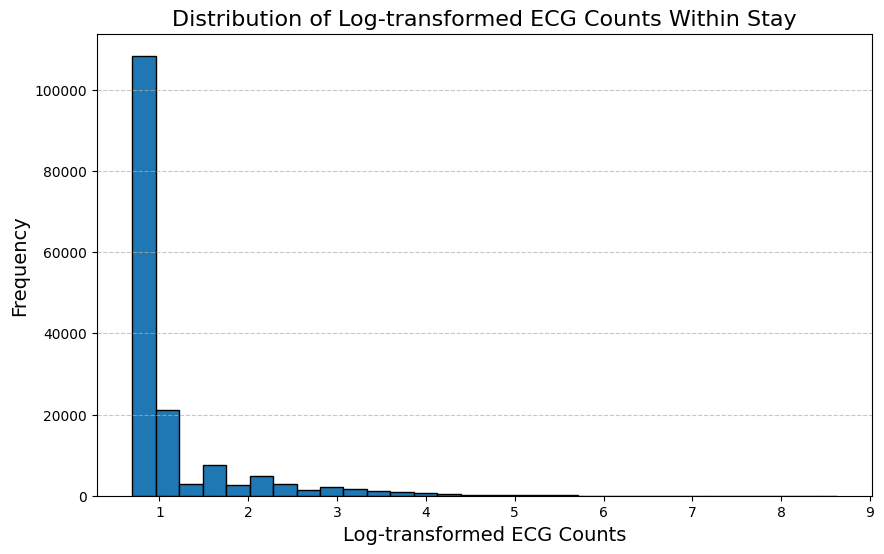

In [25]:
df_fm['lecg_no_within_stay'] = np.log(df_fm['ecg_no_within_stay']+2)

#plot log(distribution) of ECGs taken during the stay
plt.figure(figsize=(10, 6))
plt.hist(df_fm['lecg_no_within_stay'], bins=30, edgecolor='black')
plt.title('Distribution of Log-transformed ECG Counts Within Stay', fontsize=16)
plt.xlabel('Log-transformed ECG Counts', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [26]:
# Because ECG numbers show considerable right skew, we will generalize.
# Generalizing ECG numbers by binning
df_fm_generalecg = df_fm
df_fm_generalecg['binned_ecg'] = df_fm['ecg_no_within_stay'].apply(lambda x:
           0 if x in [-1, 0] else
           x if 1 <= x <= 10 else
           11 if x >10
           else x
)
df_fm_generalecg['binned_ecg'].value_counts()

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\1798313405.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fm_generalecg['binned_ecg'] = df_fm['ecg_no_within_stay'].apply(lambda x:


binned_ecg
0     108398
1      21036
11      9315
3       7509
6       3793
2       2814
10      2111
4       2045
7       1098
5        609
9        503
8        377
Name: count, dtype: int64

### Note, Gender, an ECG taken in the ED, number of ECGs provides a k = 1
### Binning ECG to 0-5 raises k to 22

In [27]:
qID = ['gender', 'ecg_taken_in_ed', 'binned_ecg']
k_anon(df_fm_generalecg, qID)

There are $48$ equivalence classes:

,gender,ecg_taken_in_ed,binned_ecg,k
0,F,False,0,30592
1,F,False,1,3636
2,F,False,2,190
3,F,False,3,1528
4,F,False,4,182
5,F,False,5,24
6,F,False,6,814
7,F,False,7,119
8,F,False,8,26
9,F,False,9,49


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=24.$

(24,
    gender  ecg_taken_in_ed  binned_ecg      k
 0       F            False           0  30592
 1       F            False           1   3636
 2       F            False           2    190
 3       F            False           3   1528
 4       F            False           4    182
 5       F            False           5     24
 6       F            False           6    814
 7       F            False           7    119
 8       F            False           8     26
 9       F            False           9     49
 10      F            False          10    473
 11      F            False          11   1354
 12      F             True           0  29190
 13      F             True           1   6796
 14      F             True           2   1211
 15      F             True           3   1825
 16      F             True           4    760
 17      F             True           5    261
 18      F             True           6    806
 19      F             True           7    385
 20     

### Binning ECGs (ecg_no_within_stay) of >5 Generalization, improves anonymity to k=22

In [28]:
# Because ECG numbers of ~10 reduce k, consider greater ECG binning
df_fm_generalecg['binned_ecg'] = df_fm['ecg_no_within_stay'].apply(lambda x:
           0 if x in [-1, 0] else
           x if 1 <= x <= 5 else
           6 if x > 5
           else x
            )
df_fm_generalecg['binned_ecg'].value_counts()

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3884209715.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fm_generalecg['binned_ecg'] = df_fm['ecg_no_within_stay'].apply(lambda x:


binned_ecg
0    108398
1     21036
6     17197
3      7509
2      2814
4      2045
5       609
Name: count, dtype: int64

In [29]:
qID = ['gender', 'ecg_taken_in_ed', 'binned_ecg']
k_anon(df_fm_generalecg, qID)

There are $28$ equivalence classes:

,gender,ecg_taken_in_ed,binned_ecg,k
0,F,False,0,30592
1,F,False,1,3636
2,F,False,2,190
3,F,False,3,1528
4,F,False,4,182
5,F,False,5,24
6,F,False,6,2835
7,F,True,0,29190
8,F,True,1,6796
9,F,True,2,1211


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=24.$

(24,
    gender  ecg_taken_in_ed  binned_ecg      k
 0       F            False           0  30592
 1       F            False           1   3636
 2       F            False           2    190
 3       F            False           3   1528
 4       F            False           4    182
 5       F            False           5     24
 6       F            False           6   2835
 7       F             True           0  29190
 8       F             True           1   6796
 9       F             True           2   1211
 10      F             True           3   1825
 11      F             True           4    760
 12      F             True           5    261
 13      F             True           6   4567
 14      M            False           0  25728
 15      M            False           1   4497
 16      M            False           2    243
 17      M            False           3   2110
 18      M            False           4    231
 19      M            False           5     44
 20     

### Adding 'gender', 'ecg_taken_in_ed', 'ecg_taken_in_hosp', 'binned_ecg' takes k back to 1 even with ECG binned 0-5
### Subsidiary analyses show that Binned ECG is a major identifier - even binned 0-5

In [30]:
qID = ['binned_ecg']
k_anon(df_fm_generalecg, qID)

There are $7$ equivalence classes:

,binned_ecg,k
0,0,108398
1,1,21036
2,2,2814
3,3,7509
4,4,2045
5,5,609
6,6,17197


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=609.$

(609,
    binned_ecg       k
 0           0  108398
 1           1   21036
 2           2    2814
 3           3    7509
 4           4    2045
 5           5     609
 6           6   17197)

In [31]:
qID = ['ecg_taken_in_ed']
k_anon(df_fm_generalecg, qID)

There are $2$ equivalence classes:

,ecg_taken_in_ed,k
0,False,75864
1,True,83744


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=75864.$

(75864,
    ecg_taken_in_ed      k
 0            False  75864
 1             True  83744)

In [32]:
qID = ['ecg_taken_in_hosp']
k_anon(df_fm_generalecg, qID)

There are $2$ equivalence classes:

,ecg_taken_in_hosp,k
0,False,77427
1,True,82181


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=77427.$

(77427,
    ecg_taken_in_hosp      k
 0              False  77427
 1               True  82181)

In [33]:
qID = ['gender', 'ecg_taken_in_ed', 'ecg_taken_in_hosp', 'binned_ecg']
k_anon(df_fm_generalecg, qID)

There are $44$ equivalence classes:

,gender,ecg_taken_in_ed,ecg_taken_in_hosp,binned_ecg,k
0,F,False,False,0,20238
1,F,False,True,0,10354
2,F,False,True,1,3636
3,F,False,True,2,190
4,F,False,True,3,1528
5,F,False,True,4,182
6,F,False,True,5,24
7,F,False,True,6,2835
8,F,True,False,0,20838
9,F,True,False,1,2451


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=3.$

(3,
    gender  ecg_taken_in_ed  ecg_taken_in_hosp  binned_ecg      k
 0       F            False              False           0  20238
 1       F            False               True           0  10354
 2       F            False               True           1   3636
 3       F            False               True           2    190
 4       F            False               True           3   1528
 5       F            False               True           4    182
 6       F            False               True           5     24
 7       F            False               True           6   2835
 8       F             True              False           0  20838
 9       F             True              False           1   2451
 10      F             True              False           2     80
 11      F             True              False           3    277
 12      F             True              False           4     19
 13      F             True              False           5      6
 14   

In [34]:
qID = ['gender', 'ecg_taken_in_ed', 'ecg_taken_in_hosp']
k_anon(df_fm_generalecg, qID)

There are $8$ equivalence classes:

,gender,ecg_taken_in_ed,ecg_taken_in_hosp,k
0,F,False,False,20238
1,F,False,True,18749
2,F,True,False,23733
3,F,True,True,20877
4,M,False,False,15410
5,M,False,True,21467
6,M,True,False,18046
7,M,True,True,21088


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=15410.$

(15410,
   gender  ecg_taken_in_ed  ecg_taken_in_hosp      k
 0      F            False              False  20238
 1      F            False               True  18749
 2      F             True              False  23733
 3      F             True               True  20877
 4      M            False              False  15410
 5      M            False               True  21467
 6      M             True              False  18046
 7      M             True               True  21088)

## k-anonymity Summary

High k-anonymity was provided by gender (Male, Female, Missing), which was k >389,000 when "missing" was excluded.  ecg_taken_in_hospital and ecg_taken_in_ed also provided high k-anonymity.

k-anonymity was very low (less privacy) for quasi-identifiers 'age', 'ecg_no_in_ed', which each included outliers (e.g. age=12, ecg_no_in_ed=102) and provided k-1 anonymity. By the inverse subset theorem, adding quasi-identifiers would not improve anonymity.

If desired, we show that generalizing these quasi-identifiers dramatically increaesd k-anonymity. We have used ecg_no_in_ed > 5, age in bands (0-29, 30-39, ... 80-89, then 90+), to increase k-anonymity.

**Finally, we show on a few passes of options that adding quasi-identifiers of 'gender', 'ecg_taken_in_ed', 'ecg_taken_in_hosp', 'binned_ecg' even with ECG binned 0-5, provides only k=1 anonymity.**

### Final processed dataframe for sensitive attribute analysis
This has
<br> - Removed 'missing' gender rows
<br> - Generalized ecg_no_within_stay (0-5)
<br> - Generalized age in bands (0-29, 30-39, ... 80-89, then 90+)

In [35]:
# Generalizing age numbers by binning
df_clean = df_fm_generalecg
df_clean['binned_age'] = df_fm_generalecg['age'].apply(lambda x:
           20 if 0 <= x < 30 else
           30 if 30 <= x < 40 else
           40 if 40 <= x < 50 else
           50 if 50 <= x < 60 else
           60 if 60 <= x < 70 else
           70 if 70 <= x < 80 else
           80 if 80 <= x < 90 else
           90 if x > 90
           else x
)
df_clean.head()

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\2372178413.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['binned_age'] = df_fm_generalecg['age'].apply(lambda x:


,subject_id,ecg_time,ed_diag_ed,ed_diag_hosp,hosp_diag_hosp,all_diag_hosp,all_diag_all,gender,age,dod,ecg_no_within_stay,ecg_taken_in_ed,ecg_taken_in_hosp,ecg_taken_in_ed_or_hosp,binned_age,lecg_no_within_stay,binned_ecg
0,10000032,2180-07-23 08:44:00,"['R4182', 'G9340'],['R4182', 'G9340']","['F319', 'J449', 'B182', 'E871', 'V462', 'I958...","['J449', 'B182', 'E871', 'R197', 'V462', 'R188...","['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...","['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...",F,52.0,2180-09-09,1,True,True,True,50.0,1.098612,1
1,10000117,2181-03-04 17:14:00,"['S72092A', 'W1830XA']","['K219', 'F419', 'Z7901', 'Z87891', 'G43909', ...",,"['E7800', 'K219', 'Z87442', 'S72012A', 'I341',...","['E7800', 'K219', 'Z87442', 'S72012A', 'I341',...",F,55.0,None,0,True,False,True,50.0,0.693147,0
2,10000285,2159-11-26 14:29:00,['R1012'],,,,['R1012'],M,34.0,None,0,True,False,True,30.0,0.693147,0
3,10000560,2189-10-03 12:54:00,,,,,,F,53.0,None,0,False,False,False,50.0,0.693147,0
4,10000635,2136-06-19 07:24:00,"['E119', 'R42', 'I10', 'E780']",,"['E119', 'R001', 'I10']","['R001', 'I10', 'E119']","['R001', 'I10', 'E119'],['E119', 'R42', 'I10',...",F,74.0,None,0,True,True,True,70.0,0.693147,0


### Exploring Selected "sensitive" ICD10 Diagnostic Codes

A literature search suggests that the following codes are among the most sensitive. Clearly, "sensitive" attribute will depend on context, but we elected to follow these codes accordingly. A list of ICD10 codes can be found here: https://www.icd10data.com/ICD10CM/Codes

F10.20: Alcohol dependence, uncomplicated.
<br>F19.20: Other psychoactive substance dependence, uncomplicated.
<br>F33.1: Major depressive disorder, recurrent, moderate.
<br>F41.1: Generalized anxiety disorder.
<br>Z32.01: Encounter for pregnancy test, result positive.
<br>Z72.51: High-risk sexual behavior.
<br>B20: Human immunodeficiency virus [HIV] disease.
<br>R64: Cachexia (may indicate advanced disease or malnutrition).
<br>Z65.5: Exposure to disaster, war, or other hostilities.
<br>F43.1: Post-traumatic stress disorder (PTSD).

### Function to add column for each sensitive attribute (ICD10 codes above)

In [36]:
#Function to add column for "sensitive" diagnosis
def add_sensitive (df, sensitive_icd_code, column_name):
    df[column_name] = 0
    df[column_name]= df['all_diag_all'].apply(lambda x: 1 if sensitive_icd_code in x else 0)

    return df

### 1. Alcohol dependence, uncomplicated (F10.20)

In [37]:
#add column for "sensitive" diagnosis F10.20

df_sens = add_sensitive (df_clean, "F1020", "alcohol")
df_sens['alcohol'].value_counts()

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = 0
C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name]= df['all_diag_all'].apply(lambda x: 1 if sensitive_icd_code in x else 0)


alcohol
0    157228
1      2380
Name: count, dtype: int64

In [38]:
alcohol_cohort = df_sens[df_sens['alcohol'] == 1]

#Using these quasi-identifiers: qID = ['gender', 'ecg_taken_in_ed', 'ecg_taken_in_hosp', 'age']
qID = ['gender', 'ecg_taken_in_ed', 'ecg_taken_in_hosp', 'age']
k_anon(alcohol_cohort, qID)

There are $348$ equivalence classes:

,gender,ecg_taken_in_ed,ecg_taken_in_hosp,age,k
0,F,False,True,20.0,2
1,F,False,True,21.0,1
2,F,False,True,22.0,1
3,F,False,True,23.0,1
4,F,False,True,25.0,1
...,...,...,...,...,...
343,M,True,True,84.0,3
344,M,True,True,85.0,2
345,M,True,True,87.0,2
346,M,True,True,88.0,2


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

(1,
     gender  ecg_taken_in_ed  ecg_taken_in_hosp   age  k
 0        F            False               True  20.0  2
 1        F            False               True  21.0  1
 2        F            False               True  22.0  1
 3        F            False               True  23.0  1
 4        F            False               True  25.0  1
 ..     ...              ...                ...   ... ..
 343      M             True               True  84.0  3
 344      M             True               True  85.0  2
 345      M             True               True  87.0  2
 346      M             True               True  88.0  2
 347      M             True               True  91.0  1
 
 [348 rows x 5 columns])

### In the alcohol cohort, k = 1 using only the presence of ECG in the ER, presence of ECG in the hospital, and binned age (in decades)

There are $24$ equivalence classes:

,ecg_taken_in_ed,ecg_taken_in_hosp,binned_age,k
0,False,True,20.0,44
1,False,True,30.0,95
2,False,True,40.0,218
3,False,True,50.0,263
4,False,True,60.0,187
5,False,True,70.0,82
6,False,True,80.0,26
7,False,True,90.0,4
8,True,False,20.0,19
9,True,False,30.0,29


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

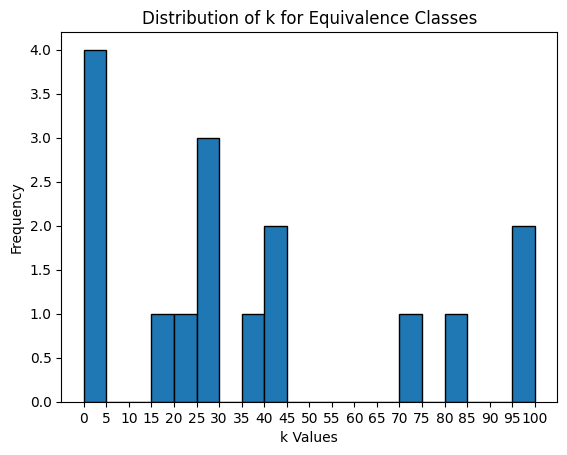

In [39]:
#Using these quasi-identifiers: qID = ['gender', 'ecg_taken_in_ed', 'ecg_taken_in_hosp', 'binned_age']
qID = ['ecg_taken_in_ed', 'ecg_taken_in_hosp', 'binned_age']
k_min, eqv_classes = k_anon(alcohol_cohort, qID)

# Plotting the histogram of k values
bins = range(0, 101, 5)

alc_figure = plt.figure()
plt.hist(eqv_classes['k'], bins=bins, edgecolor='black')
plt.title('Distribution of k for Equivalence Classes')
plt.xlabel('k Values')
plt.ylabel('Frequency')
plt.xticks(bins)


# Show the plot
plt.show()

### In the alcohol cohort, k = 1 using only the 'ecg_taken_in_ed', 'ecg_taken_in_hosp', and binned age (in decades)¶

There are $17$ equivalence classes:

,ecg_taken_in_ed,ecg_taken_in_hosp,binned_ecg,k
0,False,True,0,418
1,False,True,1,202
2,False,True,2,14
3,False,True,3,90
4,False,True,4,15
5,False,True,5,3
6,False,True,6,177
7,True,False,0,256
8,True,False,1,27
9,True,False,3,1


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

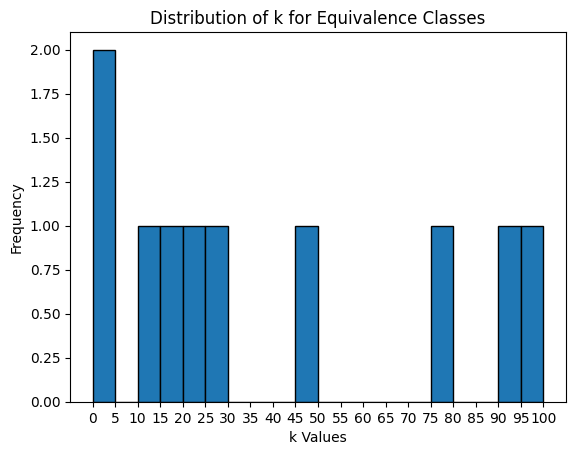

In [40]:
#Using these quasi-identifiers: qID = ['ecg_taken_in_ed', 'ecg_taken_in_hosp', 'binned_ecg']
qID = ['ecg_taken_in_ed', 'ecg_taken_in_hosp', 'binned_ecg']
k_min, eqv_classes = k_anon(alcohol_cohort, qID)

# Plotting the histogram of k values
bins = range(0, 101, 5)

alc_figure = plt.figure()
plt.hist(eqv_classes['k'], bins=bins, edgecolor='black')
plt.title('Distribution of k for Equivalence Classes')
plt.xlabel('k Values')
plt.ylabel('Frequency')
plt.xticks(bins)


# Show the plot
plt.show()

In [41]:
## K=1 also for gender, ecg_taken_in_ed, ecg_taken_in_hospital, 'age'

There are $44$ equivalence classes:

,gender,ecg_taken_in_ed,ecg_taken_in_hosp,binned_age,k
0,F,False,True,20.0,10
1,F,False,True,30.0,27
2,F,False,True,40.0,71
3,F,False,True,50.0,62
4,F,False,True,60.0,39
5,F,False,True,70.0,18
6,F,False,True,80.0,5
7,F,True,False,20.0,7
8,F,True,False,30.0,5
9,F,True,False,40.0,21


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

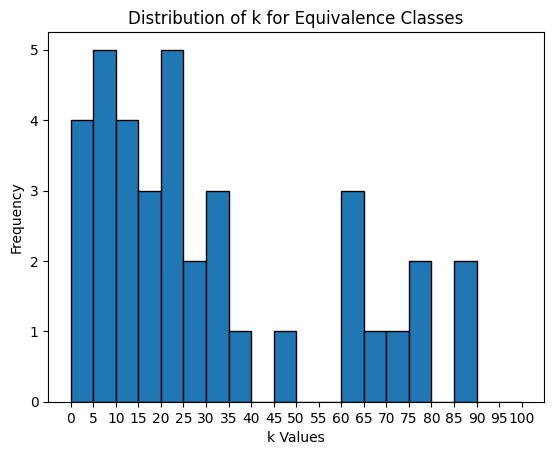

In [42]:
#Using these quasi-identifiers: qID = ['gender','ecg_taken_in_ed', 'ecg_taken_in_hosp', 'binned_age']
qID = ['gender', 'ecg_taken_in_ed', 'ecg_taken_in_hosp','binned_age']
k_min, eqv_classes = k_anon(alcohol_cohort, qID)

# Plotting the histogram of k values
bins = range(0, 101, 5)

alc_figure = plt.figure()
plt.hist(eqv_classes['k'], bins=bins, edgecolor='black')
plt.title('Distribution of k for Equivalence Classes')
plt.xlabel('k Values')
plt.ylabel('Frequency')
plt.xticks(bins)


# Show the plot
plt.show()

### Summary of k-anonymity for Alcohol

Based on this result, these generalizations are not goodin terms of the utility-privacy tradeoff, with only  k=1-anonymity (worst case across equivalence classes). Many equivalence classes are small, which may lead to a high risk of identity, attribute and membership disclosure. Conversely, utility is very high.

Ideally, we would want the distribution to be less skewed to low k-values, and shifted more towards higher k values (larger equivalence classes). Looking into additional generalizations may be more beneficial for privacy.

### 2. F19.20: Other psychoactive substance dependence, uncomplicated.

In [43]:
#add column for "sensitive" diagnosis F19.20

df_sens = add_sensitive (df_sens, "F1920", "drugs")
df_sens['drugs'].value_counts()

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = 0
C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name]= df['all_diag_all'].apply(lambda x: 1 if sensitive_icd_code in x else 0)


drugs
0    159327
1       281
Name: count, dtype: int64

There are $34$ equivalence classes:

,gender,ecg_taken_in_ed,ecg_taken_in_hosp,binned_age,k
0,F,False,True,20.0,9
1,F,False,True,30.0,3
2,F,False,True,40.0,8
3,F,False,True,50.0,2
4,F,False,True,60.0,2
5,F,False,True,70.0,1
6,F,True,False,20.0,5
7,F,True,False,30.0,3
8,F,True,False,40.0,1
9,F,True,False,50.0,3


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

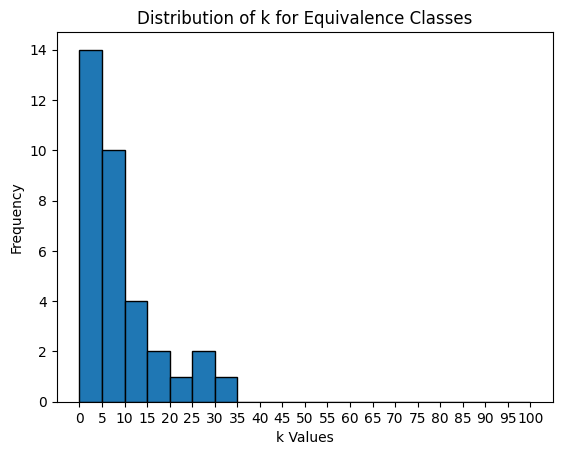

In [44]:
drugs_cohort = df_sens[df_sens['drugs'] == 1]

#Using these quasi-identifiers: qID = ['gender','ecg_taken_in_ed', 'ecg_taken_in_hosp', 'binned_age']
qID = ['gender', 'ecg_taken_in_ed', 'ecg_taken_in_hosp','binned_age']
k_min, eqv_classes = k_anon(drugs_cohort, qID)

# Plotting the histogram of k values
bins = range(0, 101, 5)

drugs_figure = plt.figure()
plt.hist(eqv_classes['k'], bins=bins, edgecolor='black')
plt.title('Distribution of k for Equivalence Classes')
plt.xlabel('k Values')
plt.ylabel('Frequency')
plt.xticks(bins)


# Show the plot
plt.show()

### 3. F33.1: Major depressive disorder, recurrent, moderate.

In [45]:
#add column for "sensitive" diagnosis F33.1

df_sens = add_sensitive (df_sens, "F331", "depression")
df_sens['depression'].value_counts()

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = 0
C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name]= df['all_diag_all'].apply(lambda x: 1 if sensitive_icd_code in x else 0)


depression
0    159539
1        69
Name: count, dtype: int64

### 4. F41.1: Generalized anxiety disorder.

In [46]:
#add column for "sensitive" diagnosis F41.1

df_sens = add_sensitive (df_sens, "F411", "anxiety")
df_sens['anxiety'].value_counts()

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = 0
C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name]= df['all_diag_all'].apply(lambda x: 1 if sensitive_icd_code in x else 0)


anxiety
0    159135
1       473
Name: count, dtype: int64

There are $45$ equivalence classes:

,gender,ecg_taken_in_ed,ecg_taken_in_hosp,binned_age,k
0,F,False,True,20.0,20
1,F,False,True,30.0,16
2,F,False,True,40.0,6
3,F,False,True,50.0,12
4,F,False,True,60.0,9
5,F,False,True,70.0,4
6,F,False,True,80.0,6
7,F,False,True,90.0,1
8,F,True,False,20.0,15
9,F,True,False,30.0,7


The best $k-Anonymity$ guarantee for `records_w_diag_icd10` is $k=1.$

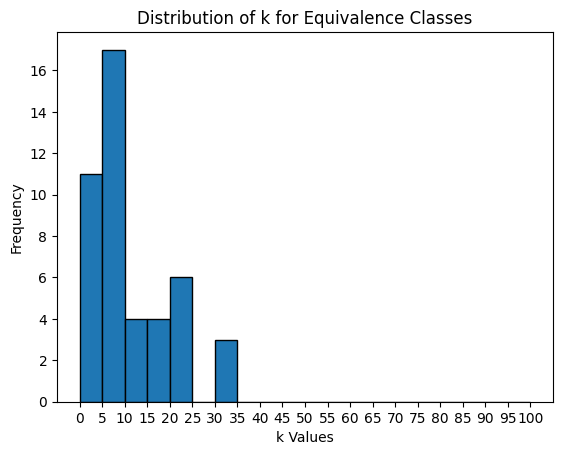

In [47]:
anxiety_cohort = df_sens[df_sens['anxiety'] == 1]

#Using these quasi-identifiers: qID = ['gender','ecg_taken_in_ed', 'ecg_taken_in_hosp', 'binned_age']
qID = ['gender', 'ecg_taken_in_ed', 'ecg_taken_in_hosp','binned_age']
k_min, eqv_classes = k_anon(anxiety_cohort, qID)

# Plotting the histogram of k values
bins = range(0, 101, 5)

anxiety_figure = plt.figure()
plt.hist(eqv_classes['k'], bins=bins, edgecolor='black')
plt.title('Distribution of k for Equivalence Classes')
plt.xlabel('k Values')
plt.ylabel('Frequency')
plt.xticks(bins)


# Show the plot
plt.show()

### 5. Z32.01: Encounter for pregnancy test, result positive.

In [48]:
#add column for "sensitive" diagnosis Z32.01

df_sens = add_sensitive (df_sens, "Z3201", "pregnancy")
df_sens['pregnancy'].value_counts()

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = 0
C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name]= df['all_diag_all'].apply(lambda x: 1 if sensitive_icd_code in x else 0)


pregnancy
0    159604
1         4
Name: count, dtype: int64

### 6. Z72.51: High-risk sexual behavior.

In [49]:
#add column for "sensitive" diagnosis Z72.51

df_sens = add_sensitive (df_sens, "Z7251", "sex_high_risk")
df_sens['sex_high_risk'].value_counts()

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = 0
C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name]= df['all_diag_all'].apply(lambda x: 1 if sensitive_icd_code in x else 0)


sex_high_risk
0    159598
1        10
Name: count, dtype: int64

### 7. B20: Human immunodeficiency virus [HIV] disease.

In [50]:
#add column for "sensitive" diagnosis B20

df_sens = add_sensitive (df_sens, "B20", "HIV")
df_sens['HIV'].value_counts()

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = 0
C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name]= df['all_diag_all'].apply(lambda x: 1 if sensitive_icd_code in x else 0)


HIV
0    158780
1       828
Name: count, dtype: int64

### 8. R64: Cachexia (may indicate advanced disease or malnutrition).

In [51]:
#add column for "sensitive" diagnosis R64

df_sens = add_sensitive (df_sens, "R64", "cachexia")
df_sens['cachexia'].value_counts()

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = 0
C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name]= df['all_diag_all'].apply(lambda x: 1 if sensitive_icd_code in x else 0)


cachexia
0    158300
1      1308
Name: count, dtype: int64

### 9. Z65.5: Exposure to disaster, war, or other hostilities.

In [52]:
#add column for "sensitive" diagnosis Z655

df_sens = add_sensitive (df_sens, "Z655", "war")
df_sens['war'].value_counts()

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = 0
C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name]= df['all_diag_all'].apply(lambda x: 1 if sensitive_icd_code in x else 0)


war
0    159607
1         1
Name: count, dtype: int64

### 10. F43.1: Post-traumatic stress disorder (PTSD).

In [53]:
#add column for "sensitive" diagnosis F431

df_sens = add_sensitive (df_sens, "F431", "PTSD")
df_sens['PTSD'].value_counts()

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = 0
C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name]= df['all_diag_all'].apply(lambda x: 1 if sensitive_icd_code in x else 0)


PTSD
0    157566
1      2042
Name: count, dtype: int64

### 11. Coronary artery bypass grafting

In [54]:
#add column for "sensitive" diagnosis F10.20

df_sens = add_sensitive (df_sens, "F1020", "cabg")
df_sens['cabg'].value_counts()

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = 0
C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_35492\3104258237.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name]= df['all_diag_all'].apply(lambda x: 1 if sensitive_icd_code in x else 0)


cabg
0    157228
1      2380
Name: count, dtype: int64

In [55]:
df_sens.tail()

,subject_id,ecg_time,ed_diag_ed,ed_diag_hosp,hosp_diag_hosp,all_diag_hosp,all_diag_all,gender,age,dod,...,drugs,depression,anxiety,pregnancy,sex_high_risk,HIV,cachexia,war,PTSD,cabg
161347,19999733,2152-07-08 21:38:00,"['T781XXA', 'R209', 'G40909', 'X58XXXA']","['T7840XA', 'Y92099']",,"['T7840XA', 'Y92099']","['T7840XA', 'Y92099']",F,19.0,None,...,0,0,0,0,0,0,0,0,0,0
161348,19999784,2119-06-18 17:52:00,['R531'],"['M5416', 'C8599', 'D649', 'E440', 'D72819', '...","['Z720', 'C8339', 'Y92239', 'Z6822', 'G9782', ...","['D649', 'D472', 'E440', 'D72819', 'Z6823', 'G...","['D649', 'D472', 'E440', 'D72819', 'Z6823', 'G...",M,57.0,None,...,0,0,0,0,0,0,0,0,0,0
161349,19999828,2147-07-29 11:59:00,,,"['F419', 'F1290', 'I8390', 'I10', 'Z7984', 'E1...","['I9581', 'M5430', 'I8390', 'Z7984', 'F1290', ...","['I9581', 'M5430', 'I8390', 'Z7984', 'F1290', ...",F,46.0,None,...,0,0,0,0,0,0,0,0,0,0
161350,19999840,2164-07-24 22:31:00,,,"['I69920', 'G40909', 'E785', 'I69959', 'I6350'...","['E785', 'I6350', 'I10', 'F17200', 'G40909', '...","['E785', 'I6350', 'I10', 'F17200', 'G40909', '...",M,58.0,2164-09-17,...,0,0,0,0,0,0,0,0,0,0
161351,19999987,2145-11-02 19:54:00,['I619'],"['N390', 'R569', 'C8589', 'E039', 'G936', 'H53...","['N390', 'R569', 'C8589', 'E039', 'G936', 'H53...","['H53469', 'R569', 'N390', 'E039', 'I619', 'I2...","['H53469', 'R569', 'N390', 'E039', 'I619', 'I2...",F,57.0,None,...,0,0,0,0,0,0,0,0,0,0


# Run the kAnonymity_Analyze function with generalized ECG on varying sets of quasi-identifiers

## Edward: Please Run Distinct or Entropy L-diversity for various combinations of quasi-identifiers.
We should decide which ones...

## Rohan: Please Run t-closeness for various combinations of quasi-identifiers.
We should decide which ones...

##EMD Ordered Distance for Binary (T/F) Sensitive Attributes (ECG attributes)

In [56]:
'''def EMD_ordered_distance_binary(data_table, quasi_identifiers, sensitive_column):
    # Define the sensitive value order and mapping
    sensitive_values_order = [False, True]
    sensitive_order_mapping = {v: i for i, v in enumerate(sensitive_values_order)}

    # Handle missing values in the sensitive column
    data_table = data_table.dropna(subset=[sensitive_column])

    equivalence_classes = data_table.groupby(quasi_identifiers)
    emd_values = []

    for name, group in equivalence_classes:
        class_sensitive_values = group[sensitive_column]

        # Compute class and overall distributions
        class_distribution = class_sensitive_values.value_counts(
            normalize=True
        ).sort_index()
        overall_distribution = (
            data_table[sensitive_column].value_counts(normalize=True).sort_index()
        )

        # Map sensitive values to their ordered indices
        class_mapped = class_distribution.index.map(sensitive_order_mapping)
        overall_mapped = overall_distribution.index.map(sensitive_order_mapping)

        # Calculate EMD
        if not class_mapped.isna().any() and not overall_mapped.isna().any():
            emd = wasserstein_distance(
                class_mapped,
                overall_mapped,
                u_weights=class_distribution.values,
                v_weights=overall_distribution.values,
            )
        else:
            emd = None
        emd_values.append(emd)

    equivalence_class_data = equivalence_classes.size().reset_index(name="size")
    equivalence_class_data["EMD"] = emd_values

    # Calculate the best t value for t-closeness
    t_closeness_value = max(filter(None, emd_values)) if emd_values else 0

    return t_closeness_value, equivalence_class_data'''

'def EMD_ordered_distance_binary(data_table, quasi_identifiers, sensitive_column):\n    # Define the sensitive value order and mapping\n    sensitive_values_order = [False, True]\n    sensitive_order_mapping = {v: i for i, v in enumerate(sensitive_values_order)}\n\n    # Handle missing values in the sensitive column\n    data_table = data_table.dropna(subset=[sensitive_column])\n\n    equivalence_classes = data_table.groupby(quasi_identifiers)\n    emd_values = []\n\n    for name, group in equivalence_classes:\n        class_sensitive_values = group[sensitive_column]\n\n        # Compute class and overall distributions\n        class_distribution = class_sensitive_values.value_counts(\n            normalize=True\n        ).sort_index()\n        overall_distribution = (\n            data_table[sensitive_column].value_counts(normalize=True).sort_index()\n        )\n\n        # Map sensitive values to their ordered indices\n        class_mapped = class_distribution.index.map(sensitive_ord

EMD Ordered Distance for Binary (1/0) SA

In [57]:
'''def EMD_ordered_distance_binary_num(data_table, quasi_identifiers, sensitive_column):
    # Define the sensitive value order and mapping
    sensitive_values_order = [0, 1]
    sensitive_order_mapping = {v: i for i, v in enumerate(sensitive_values_order)}

    # Handle missing values in the sensitive column
    data_table = data_table.dropna(subset=[sensitive_column])

    equivalence_classes = data_table.groupby(quasi_identifiers)
    emd_values = []

    for name, group in equivalence_classes:
        class_sensitive_values = group[sensitive_column]

        # Compute class and overall distributions
        class_distribution = class_sensitive_values.value_counts(
            normalize=True
        ).sort_index()
        overall_distribution = (
            data_table[sensitive_column].value_counts(normalize=True).sort_index()
        )

        # Map sensitive values to their ordered indices
        class_mapped = class_distribution.index.map(sensitive_order_mapping)
        overall_mapped = overall_distribution.index.map(sensitive_order_mapping)

        # Calculate EMD
        if not class_mapped.isna().any() and not overall_mapped.isna().any():
            emd = wasserstein_distance(
                class_mapped,
                overall_mapped,
                u_weights=class_distribution.values,
                v_weights=overall_distribution.values,
            )
        else:
            emd = None
        emd_values.append(emd)

    equivalence_class_data = equivalence_classes.size().reset_index(name="size")
    equivalence_class_data["EMD"] = emd_values

    # Calculate the best t value for t-closeness
    t_closeness_value = max(filter(None, emd_values)) if emd_values else 0

    return t_closeness_value, equivalence_class_data'''

'def EMD_ordered_distance_binary_num(data_table, quasi_identifiers, sensitive_column):\n    # Define the sensitive value order and mapping\n    sensitive_values_order = [0, 1]\n    sensitive_order_mapping = {v: i for i, v in enumerate(sensitive_values_order)}\n\n    # Handle missing values in the sensitive column\n    data_table = data_table.dropna(subset=[sensitive_column])\n\n    equivalence_classes = data_table.groupby(quasi_identifiers)\n    emd_values = []\n\n    for name, group in equivalence_classes:\n        class_sensitive_values = group[sensitive_column]\n\n        # Compute class and overall distributions\n        class_distribution = class_sensitive_values.value_counts(\n            normalize=True\n        ).sort_index()\n        overall_distribution = (\n            data_table[sensitive_column].value_counts(normalize=True).sort_index()\n        )\n\n        # Map sensitive values to their ordered indices\n        class_mapped = class_distribution.index.map(sensitive_order_

###EMD Exploratory Analysis

In [58]:
'''quasi_identifiers = ["age", "gender", "ecg_taken_in_hosp"]
sensitive_column = "ecg_taken_in_ed"

# Run the function
t_closeness_value, equivalence_classes = EMD_ordered_distance_binary(
    df, quasi_identifiers, sensitive_column
)

# Display results
print(f"T-Closeness Value: {t_closeness_value}")
print(equivalence_classes)
# Filter equivalence classes where EMD is greater than 0.3
greater_than_03 = equivalence_classes[equivalence_classes["EMD"] > 0.3]

# Filter equivalence classes where EMD is less than or equal to 0.3
less_than_or_equal_03 = equivalence_classes[equivalence_classes["EMD"] <= 0.3]

# Group by the attributes and count the records
grouped_counts = (
    df.groupby(["age", "gender", "ecg_taken_in_hosp"]).size().reset_index(name="count")
)

# Merge the grouped counts with the equivalence class data (assuming it contains EMD values)
merged_data_low = grouped_counts.merge(
    less_than_or_equal_03, on=["age", "gender", "ecg_taken_in_hosp"], how="left"
)
merged_data_high = grouped_counts.merge(
    greater_than_03, on=["age", "gender", "ecg_taken_in_hosp"], how="left"
)

# Sort by the EMD values in descending order
sorted_by_emd = merged_data_high.sort_values(by="EMD", ascending=False)
descend_by_emd = merged_data_low.sort_values(by="EMD", ascending=True)

# Display the sorted data
print("High Levels of EMD")
print(sorted_by_emd)
print("Low Levels of EMD")
print(descend_by_emd)'''


'quasi_identifiers = ["age", "gender", "ecg_taken_in_hosp"]\nsensitive_column = "ecg_taken_in_ed"\n\n# Run the function\nt_closeness_value, equivalence_classes = EMD_ordered_distance_binary(\n    df, quasi_identifiers, sensitive_column\n)\n\n# Display results\nprint(f"T-Closeness Value: {t_closeness_value}")\nprint(equivalence_classes)\n# Filter equivalence classes where EMD is greater than 0.3\ngreater_than_03 = equivalence_classes[equivalence_classes["EMD"] > 0.3]\n\n# Filter equivalence classes where EMD is less than or equal to 0.3\nless_than_or_equal_03 = equivalence_classes[equivalence_classes["EMD"] <= 0.3]\n\n# Group by the attributes and count the records\ngrouped_counts = (\n    df.groupby(["age", "gender", "ecg_taken_in_hosp"]).size().reset_index(name="count")\n)\n\n# Merge the grouped counts with the equivalence class data (assuming it contains EMD values)\nmerged_data_low = grouped_counts.merge(\n    less_than_or_equal_03, on=["age", "gender", "ecg_taken_in_hosp"], how="le

In [59]:
'''quasi_identifiers = ["binned_age", "ecg_taken_in_hosp"]
sensitive_column = "alcohol"

# Run the function
t_closeness_value, equivalence_classes = EMD_ordered_distance_binary_num(
    df_sens, quasi_identifiers, sensitive_column
)

# Display results
print(f"T-Closeness Value: {t_closeness_value}")
print(equivalence_classes)
# Filter equivalence classes where EMD is greater than 0.3
greater_than_03 = equivalence_classes[equivalence_classes["EMD"] > 0.3]

# Filter equivalence classes where EMD is less than or equal to 0.3
less_than_or_equal_03 = equivalence_classes[equivalence_classes["EMD"] <= 0.3]

# Group by the attributes and count the records
grouped_counts = (
    df_sens.groupby(["binned_age", "ecg_taken_in_hosp"]).size().reset_index(name="count")
)

# Merge the grouped counts with the equivalence class data (assuming it contains EMD values)
merged_data_low = grouped_counts.merge(
    less_than_or_equal_03, on=["binned_age", "ecg_taken_in_hosp"], how="left"
)
merged_data_high = grouped_counts.merge(
    greater_than_03, on=["binned_age", "ecg_taken_in_hosp"], how="left"
)

# Sort by the EMD values in descending order
sorted_by_emd = merged_data_high.sort_values(by="EMD", ascending=False)
descend_by_emd = merged_data_low.sort_values(by="EMD", ascending=True)

# Display the sorted data
print("High Levels of EMD")
print(sorted_by_emd)
print("Low Levels of EMD")
print(descend_by_emd)'''


'quasi_identifiers = ["binned_age", "ecg_taken_in_hosp"]\nsensitive_column = "alcohol"\n\n# Run the function\nt_closeness_value, equivalence_classes = EMD_ordered_distance_binary_num(\n    df_sens, quasi_identifiers, sensitive_column\n)\n\n# Display results\nprint(f"T-Closeness Value: {t_closeness_value}")\nprint(equivalence_classes)\n# Filter equivalence classes where EMD is greater than 0.3\ngreater_than_03 = equivalence_classes[equivalence_classes["EMD"] > 0.3]\n\n# Filter equivalence classes where EMD is less than or equal to 0.3\nless_than_or_equal_03 = equivalence_classes[equivalence_classes["EMD"] <= 0.3]\n\n# Group by the attributes and count the records\ngrouped_counts = (\n    df_sens.groupby(["binned_age", "ecg_taken_in_hosp"]).size().reset_index(name="count")\n)\n\n# Merge the grouped counts with the equivalence class data (assuming it contains EMD values)\nmerged_data_low = grouped_counts.merge(\n    less_than_or_equal_03, on=["binned_age", "ecg_taken_in_hosp"], how="left"

##T Closeness For DF_Clean and Binned Attributes

In [60]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance


def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["binned_age", "gender"]
sensitive_attribute = "drugs"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_clean, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


Equivalence Class (20.0, 'F'): t-Closeness Score = 0.0004
Equivalence Class (20.0, 'M'): t-Closeness Score = 0.0028
Equivalence Class (30.0, 'F'): t-Closeness Score = 0.0004
Equivalence Class (30.0, 'M'): t-Closeness Score = 0.0057
Equivalence Class (40.0, 'F'): t-Closeness Score = 0.0014
Equivalence Class (40.0, 'M'): t-Closeness Score = 0.0027
Equivalence Class (50.0, 'F'): t-Closeness Score = 0.0007
Equivalence Class (50.0, 'M'): t-Closeness Score = 0.0005
Equivalence Class (60.0, 'F'): t-Closeness Score = 0.0011
Equivalence Class (60.0, 'M'): t-Closeness Score = 0.0008
Equivalence Class (70.0, 'F'): t-Closeness Score = 0.0016
Equivalence Class (70.0, 'M'): t-Closeness Score = 0.0013
Equivalence Class (80.0, 'F'): t-Closeness Score = 0.0016
Equivalence Class (80.0, 'M'): t-Closeness Score = 0.0018
Equivalence Class (90.0, 'F'): t-Closeness Score = 0.0015
Equivalence Class (90.0, 'M'): t-Closeness Score = 0.0018


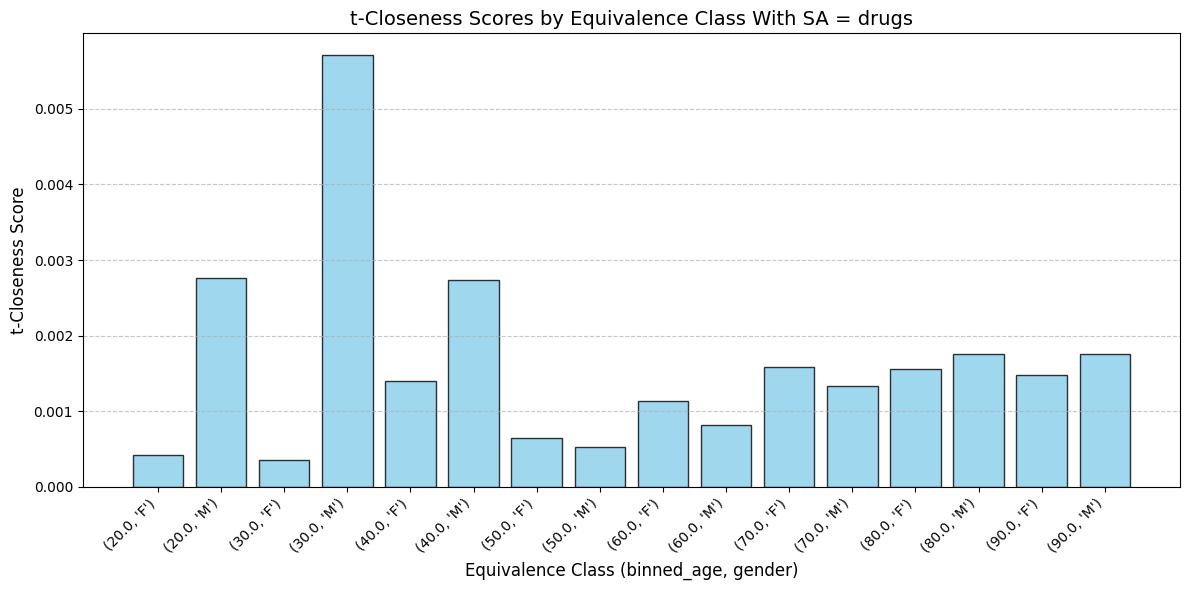

In [61]:

# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = drugs", fontsize=14)
plt.xlabel("Equivalence Class (binned_age, gender)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


###EMD DF Sens


In [62]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance


def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["binned_age", "gender"]
sensitive_attribute = "anxiety"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_sens, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


Equivalence Class (20.0, 'F'): t-Closeness Score = 0.0031
Equivalence Class (20.0, 'M'): t-Closeness Score = 0.0010
Equivalence Class (30.0, 'F'): t-Closeness Score = 0.0017
Equivalence Class (30.0, 'M'): t-Closeness Score = 0.0004
Equivalence Class (40.0, 'F'): t-Closeness Score = 0.0006
Equivalence Class (40.0, 'M'): t-Closeness Score = 0.0006
Equivalence Class (50.0, 'F'): t-Closeness Score = 0.0002
Equivalence Class (50.0, 'M'): t-Closeness Score = 0.0005
Equivalence Class (60.0, 'F'): t-Closeness Score = 0.0003
Equivalence Class (60.0, 'M'): t-Closeness Score = 0.0006
Equivalence Class (70.0, 'F'): t-Closeness Score = 0.0006
Equivalence Class (70.0, 'M'): t-Closeness Score = 0.0015
Equivalence Class (80.0, 'F'): t-Closeness Score = 0.0009
Equivalence Class (80.0, 'M'): t-Closeness Score = 0.0017
Equivalence Class (90.0, 'F'): t-Closeness Score = 0.0010
Equivalence Class (90.0, 'M'): t-Closeness Score = 0.0024


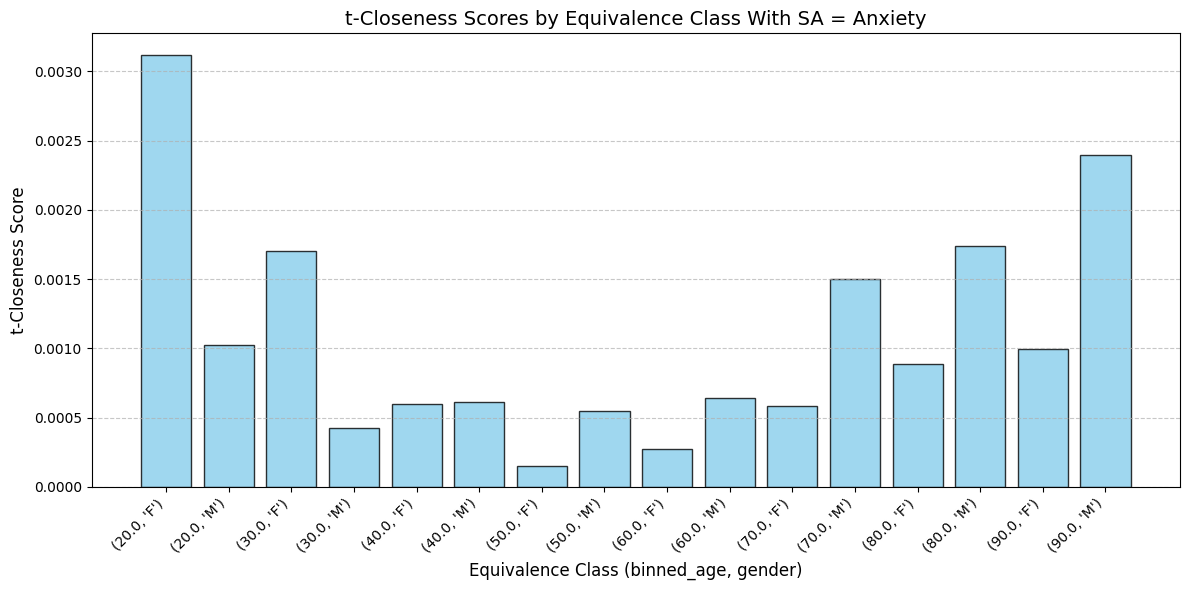

In [63]:
##Age and Gender With SA Anxiety
# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = Anxiety", fontsize=14)
plt.xlabel("Equivalence Class (binned_age, gender)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [64]:

def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["binned_age", "gender"]
sensitive_attribute = "alcohol"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_sens, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


Equivalence Class (20.0, 'F'): t-Closeness Score = 0.0124
Equivalence Class (20.0, 'M'): t-Closeness Score = 0.0056
Equivalence Class (30.0, 'F'): t-Closeness Score = 0.0076
Equivalence Class (30.0, 'M'): t-Closeness Score = 0.0105
Equivalence Class (40.0, 'F'): t-Closeness Score = 0.0026
Equivalence Class (40.0, 'M'): t-Closeness Score = 0.0241
Equivalence Class (50.0, 'F'): t-Closeness Score = 0.0017
Equivalence Class (50.0, 'M'): t-Closeness Score = 0.0200
Equivalence Class (60.0, 'F'): t-Closeness Score = 0.0071
Equivalence Class (60.0, 'M'): t-Closeness Score = 0.0084
Equivalence Class (70.0, 'F'): t-Closeness Score = 0.0103
Equivalence Class (70.0, 'M'): t-Closeness Score = 0.0006
Equivalence Class (80.0, 'F'): t-Closeness Score = 0.0135
Equivalence Class (80.0, 'M'): t-Closeness Score = 0.0095
Equivalence Class (90.0, 'F'): t-Closeness Score = 0.0149
Equivalence Class (90.0, 'M'): t-Closeness Score = 0.0115


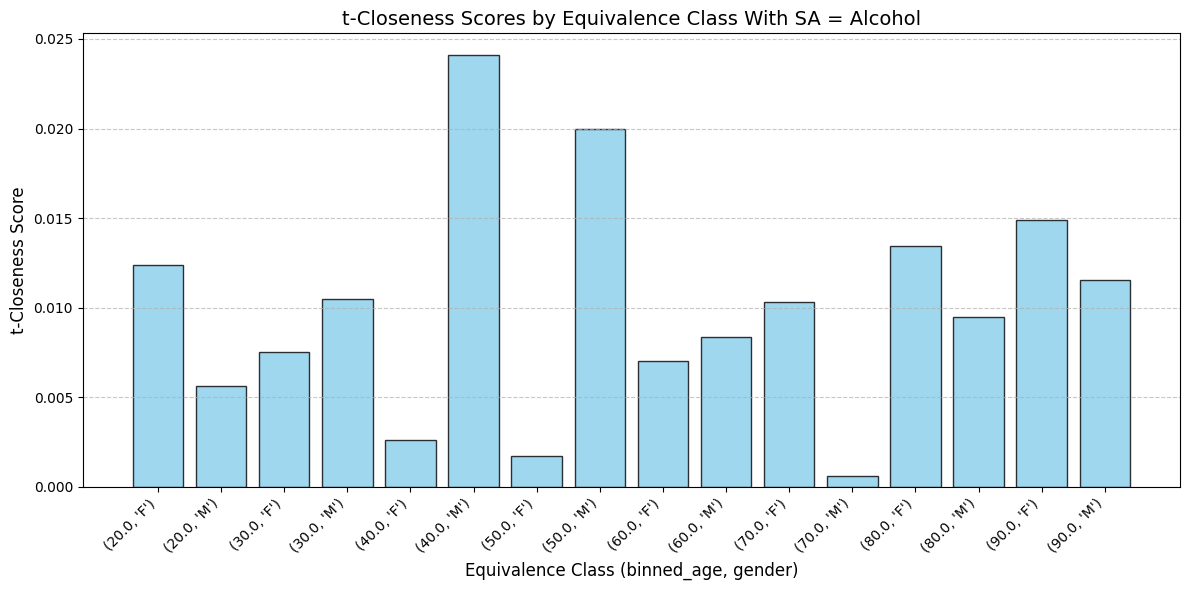

In [65]:
##Age and Gender With SA Anxiety
# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = Alcohol", fontsize=14)
plt.xlabel("Equivalence Class (binned_age, gender)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Equivalence Class (20.0, 'F', False): t-Closeness Score = 0.0012
Equivalence Class (20.0, 'F', True): t-Closeness Score = 0.0188
Equivalence Class (20.0, 'M', False): t-Closeness Score = 0.0018
Equivalence Class (20.0, 'M', True): t-Closeness Score = 0.0081
Equivalence Class (30.0, 'F', False): t-Closeness Score = 0.0018
Equivalence Class (30.0, 'F', True): t-Closeness Score = 0.0099
Equivalence Class (30.0, 'M', False): t-Closeness Score = 0.0027
Equivalence Class (30.0, 'M', True): t-Closeness Score = 0.0033
Equivalence Class (40.0, 'F', False): t-Closeness Score = 0.0019
Equivalence Class (40.0, 'F', True): t-Closeness Score = 0.0040
Equivalence Class (40.0, 'M', False): t-Closeness Score = 0.0018
Equivalence Class (40.0, 'M', True): t-Closeness Score = 0.0030
Equivalence Class (50.0, 'F', False): t-Closeness Score = 0.0026
Equivalence Class (50.0, 'F', True): t-Closeness Score = 0.0034
Equivalence Class (50.0, 'M', False): t-Closeness Score = 0.0021
Equivalence Class (50.0, 'M', Tr

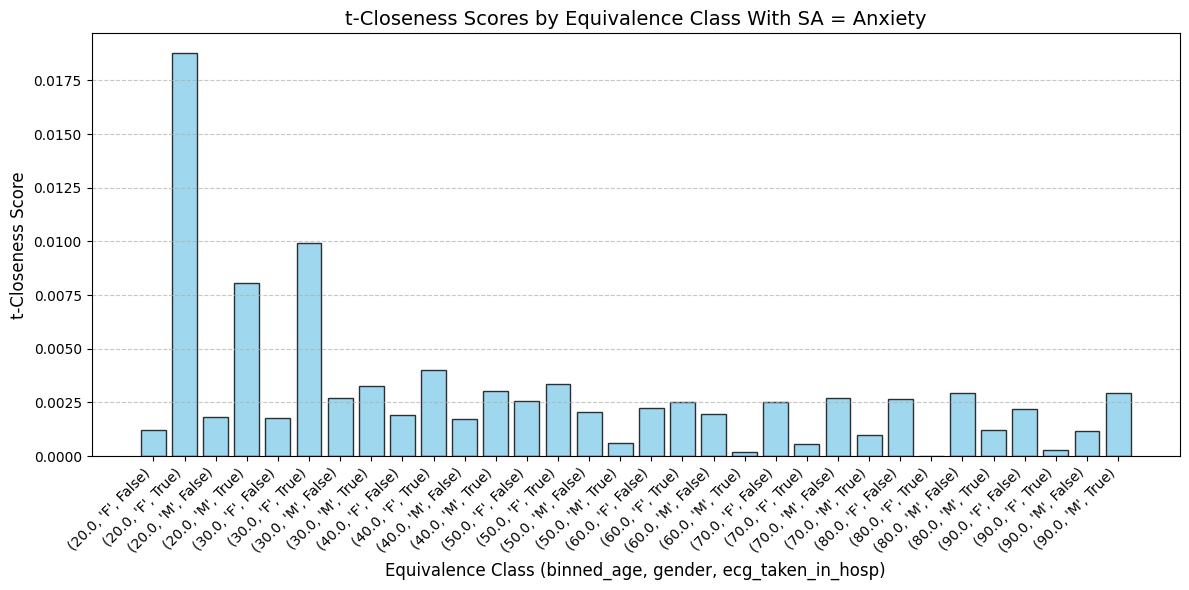

In [66]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance


def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["binned_age", "gender", "ecg_taken_in_hosp"]
sensitive_attribute = "anxiety"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_sens, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


##Age and Gender With SA Anxiety
# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = Anxiety", fontsize=14)
plt.xlabel("Equivalence Class (binned_age, gender, ecg_taken_in_hosp)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Equivalence Class (20.0, 'F', False): t-Closeness Score = 0.0141
Equivalence Class (20.0, 'F', True): t-Closeness Score = 0.0061
Equivalence Class (20.0, 'M', False): t-Closeness Score = 0.0127
Equivalence Class (20.0, 'M', True): t-Closeness Score = 0.0117
Equivalence Class (30.0, 'F', False): t-Closeness Score = 0.0141
Equivalence Class (30.0, 'F', True): t-Closeness Score = 0.0078
Equivalence Class (30.0, 'M', False): t-Closeness Score = 0.0091
Equivalence Class (30.0, 'M', True): t-Closeness Score = 0.0419
Equivalence Class (40.0, 'F', False): t-Closeness Score = 0.0113
Equivalence Class (40.0, 'F', True): t-Closeness Score = 0.0214
Equivalence Class (40.0, 'M', False): t-Closeness Score = 0.0050
Equivalence Class (40.0, 'M', True): t-Closeness Score = 0.0539
Equivalence Class (50.0, 'F', False): t-Closeness Score = 0.0123
Equivalence Class (50.0, 'F', True): t-Closeness Score = 0.0107
Equivalence Class (50.0, 'M', False): t-Closeness Score = 0.0032
Equivalence Class (50.0, 'M', Tr

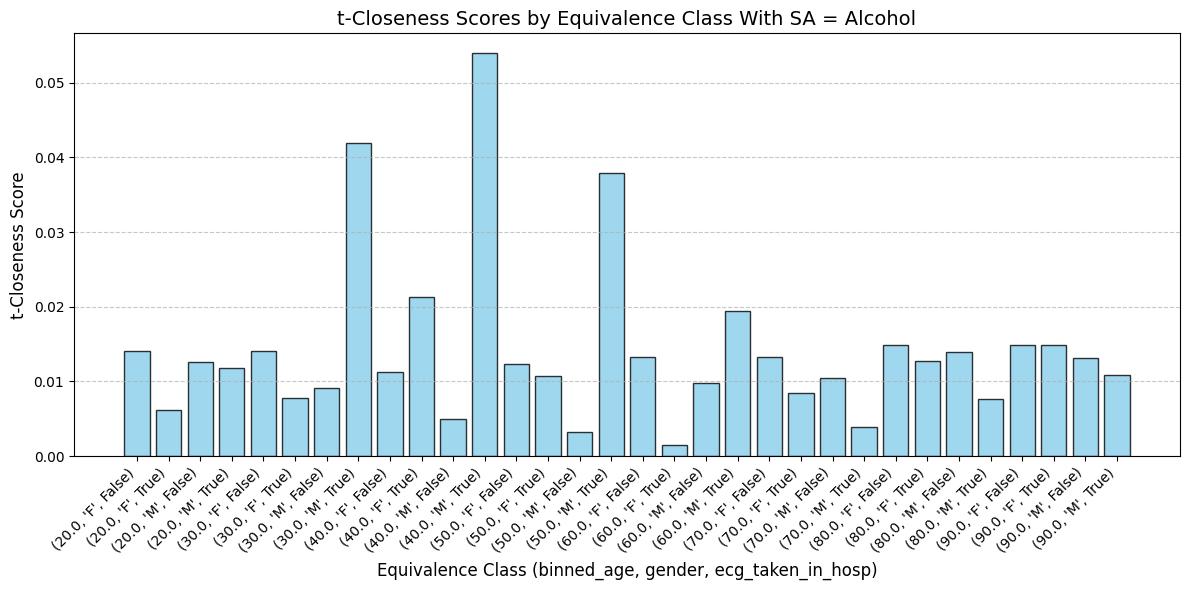

In [67]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance


def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["binned_age", "gender", "ecg_taken_in_hosp"]
sensitive_attribute = "alcohol"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_sens, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


##Age and Gender With SA Anxiety
# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = Alcohol", fontsize=14)
plt.xlabel("Equivalence Class (binned_age, gender, ecg_taken_in_hosp)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Equivalence Class (20.0, 'F', False): t-Closeness Score = 0.0012
Equivalence Class (20.0, 'F', True): t-Closeness Score = 0.0062
Equivalence Class (20.0, 'M', False): t-Closeness Score = 0.0008
Equivalence Class (20.0, 'M', True): t-Closeness Score = 0.0116
Equivalence Class (30.0, 'F', False): t-Closeness Score = 0.0013
Equivalence Class (30.0, 'F', True): t-Closeness Score = 0.0018
Equivalence Class (30.0, 'M', False): t-Closeness Score = 0.0009
Equivalence Class (30.0, 'M', True): t-Closeness Score = 0.0134
Equivalence Class (40.0, 'F', False): t-Closeness Score = 0.0016
Equivalence Class (40.0, 'F', True): t-Closeness Score = 0.0054
Equivalence Class (40.0, 'M', False): t-Closeness Score = 0.0012
Equivalence Class (40.0, 'M', True): t-Closeness Score = 0.0067
Equivalence Class (50.0, 'F', False): t-Closeness Score = 0.0014
Equivalence Class (50.0, 'F', True): t-Closeness Score = 0.0002
Equivalence Class (50.0, 'M', False): t-Closeness Score = 0.0015
Equivalence Class (50.0, 'M', Tr

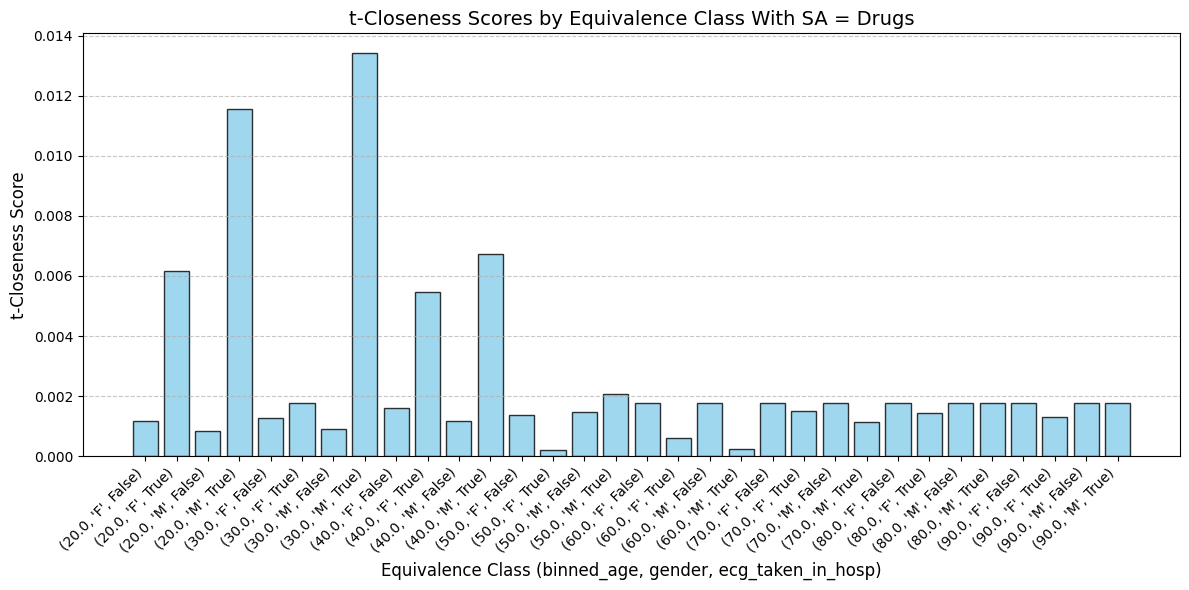

In [68]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance


def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["binned_age", "gender", "ecg_taken_in_hosp"]
sensitive_attribute = "drugs"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_sens, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


##Age and Gender With SA Anxiety
# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = Drugs", fontsize=14)
plt.xlabel("Equivalence Class (binned_age, gender, ecg_taken_in_hosp)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Equivalence Class (20.0, 0): t-Closeness Score = 0.0110
Equivalence Class (20.0, 1): t-Closeness Score = 0.0007
Equivalence Class (20.0, 2): t-Closeness Score = 0.0149
Equivalence Class (20.0, 3): t-Closeness Score = 0.0045
Equivalence Class (20.0, 4): t-Closeness Score = 0.0387
Equivalence Class (20.0, 5): t-Closeness Score = 0.0149
Equivalence Class (20.0, 6): t-Closeness Score = 0.0042
Equivalence Class (30.0, 0): t-Closeness Score = 0.0065
Equivalence Class (30.0, 1): t-Closeness Score = 0.0215
Equivalence Class (30.0, 2): t-Closeness Score = 0.0552
Equivalence Class (30.0, 3): t-Closeness Score = 0.0532
Equivalence Class (30.0, 4): t-Closeness Score = 0.0221
Equivalence Class (30.0, 5): t-Closeness Score = 0.0149
Equivalence Class (30.0, 6): t-Closeness Score = 0.0464
Equivalence Class (40.0, 0): t-Closeness Score = 0.0012
Equivalence Class (40.0, 1): t-Closeness Score = 0.0252
Equivalence Class (40.0, 2): t-Closeness Score = 0.0748
Equivalence Class (40.0, 3): t-Closeness Score =

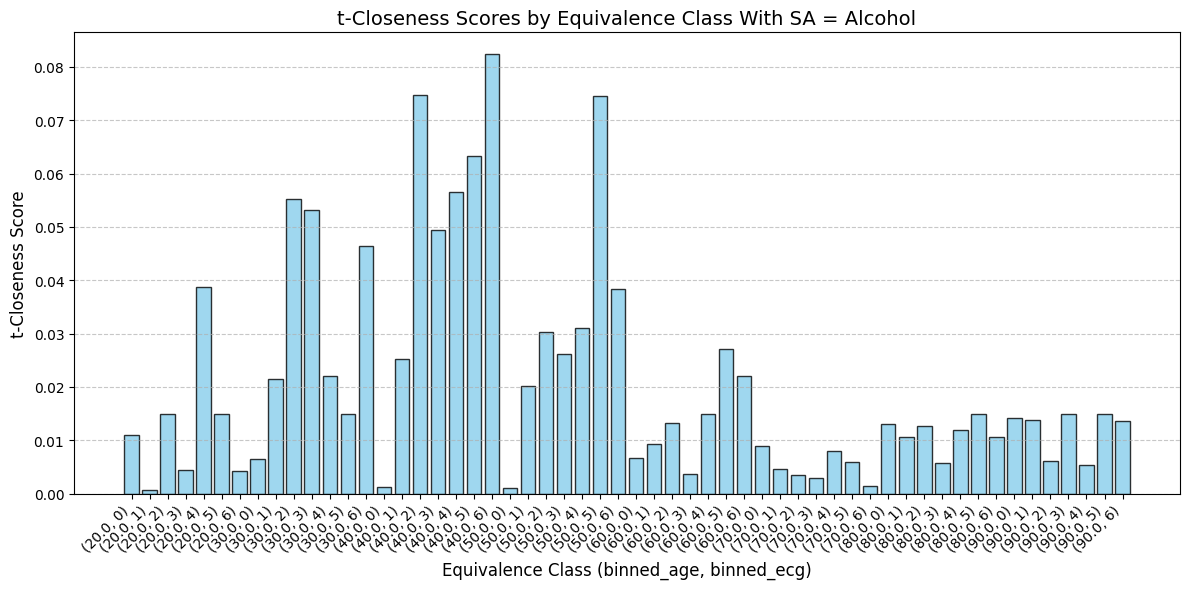

In [69]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance


def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["binned_age", "binned_ecg"]
sensitive_attribute = "alcohol"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_sens, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


##Age and Gender With SA Anxiety
# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = Alcohol", fontsize=14)
plt.xlabel("Equivalence Class (binned_age, binned_ecg)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Equivalence Class (20.0, 'F', False): t-Closeness Score = 0.0128
Equivalence Class (20.0, 'F', True): t-Closeness Score = 0.0121
Equivalence Class (20.0, 'M', False): t-Closeness Score = 0.0046
Equivalence Class (20.0, 'M', True): t-Closeness Score = 0.0064
Equivalence Class (30.0, 'F', False): t-Closeness Score = 0.0082
Equivalence Class (30.0, 'F', True): t-Closeness Score = 0.0070
Equivalence Class (30.0, 'M', False): t-Closeness Score = 0.0075
Equivalence Class (30.0, 'M', True): t-Closeness Score = 0.0129
Equivalence Class (40.0, 'F', False): t-Closeness Score = 0.0002
Equivalence Class (40.0, 'F', True): t-Closeness Score = 0.0052
Equivalence Class (40.0, 'M', False): t-Closeness Score = 0.0157
Equivalence Class (40.0, 'M', True): t-Closeness Score = 0.0322
Equivalence Class (50.0, 'F', False): t-Closeness Score = 0.0061
Equivalence Class (50.0, 'F', True): t-Closeness Score = 0.0024
Equivalence Class (50.0, 'M', False): t-Closeness Score = 0.0118
Equivalence Class (50.0, 'M', Tr

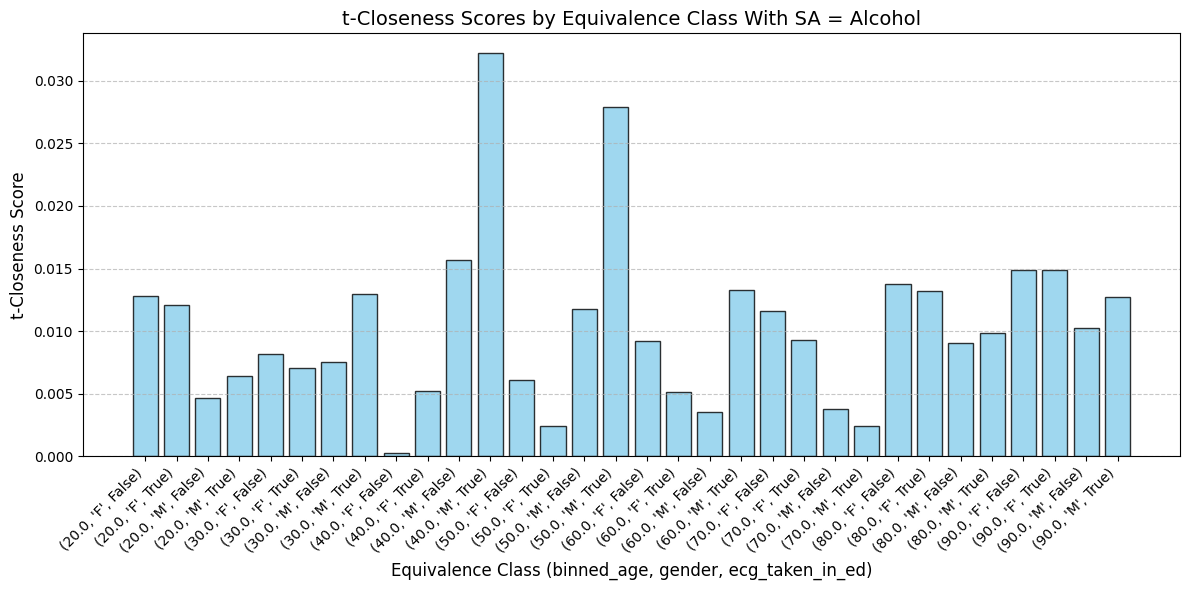

In [70]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance


def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["binned_age", "gender", "ecg_taken_in_ed"]
sensitive_attribute = "alcohol"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_sens, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


##Age and Gender With SA Anxiety
# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = Alcohol", fontsize=14)
plt.xlabel("Equivalence Class (binned_age, gender, ecg_taken_in_ed)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Equivalence Class (20.0, 0): t-Closeness Score = 0.0011
Equivalence Class (20.0, 1): t-Closeness Score = 0.0060
Equivalence Class (20.0, 2): t-Closeness Score = 0.0296
Equivalence Class (20.0, 3): t-Closeness Score = 0.0040
Equivalence Class (20.0, 4): t-Closeness Score = 0.0685
Equivalence Class (20.0, 5): t-Closeness Score = 0.0030
Equivalence Class (20.0, 6): t-Closeness Score = 0.0183
Equivalence Class (30.0, 0): t-Closeness Score = 0.0003
Equivalence Class (30.0, 1): t-Closeness Score = 0.0018
Equivalence Class (30.0, 2): t-Closeness Score = 0.0030
Equivalence Class (30.0, 3): t-Closeness Score = 0.0063
Equivalence Class (30.0, 4): t-Closeness Score = 0.0341
Equivalence Class (30.0, 5): t-Closeness Score = 0.0447
Equivalence Class (30.0, 6): t-Closeness Score = 0.0132
Equivalence Class (40.0, 0): t-Closeness Score = 0.0011
Equivalence Class (40.0, 1): t-Closeness Score = 0.0023
Equivalence Class (40.0, 2): t-Closeness Score = 0.0070
Equivalence Class (40.0, 3): t-Closeness Score =

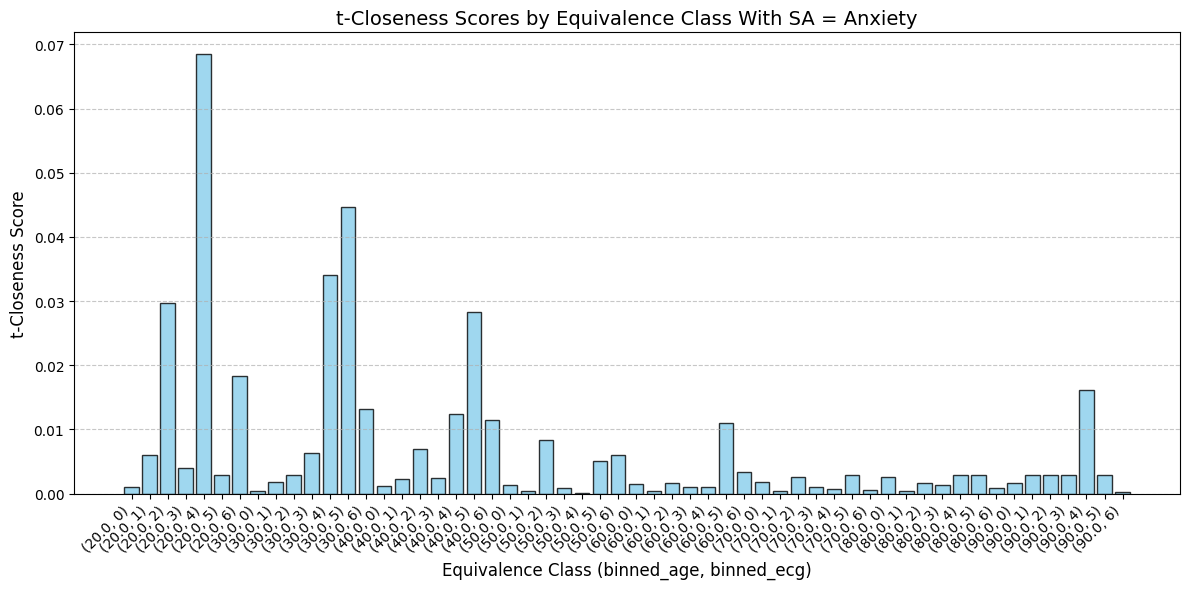

In [71]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance


def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["binned_age", "binned_ecg"]
sensitive_attribute = "anxiety"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_sens, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


##Age and Gender With SA Anxiety
# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = Anxiety", fontsize=14)
plt.xlabel("Equivalence Class (binned_age, binned_ecg)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Equivalence Class (20.0, 0): t-Closeness Score = 0.0000
Equivalence Class (20.0, 1): t-Closeness Score = 0.0072
Equivalence Class (20.0, 2): t-Closeness Score = 0.0200
Equivalence Class (20.0, 3): t-Closeness Score = 0.0087
Equivalence Class (20.0, 4): t-Closeness Score = 0.0018
Equivalence Class (20.0, 5): t-Closeness Score = 0.0018
Equivalence Class (20.0, 6): t-Closeness Score = 0.0238
Equivalence Class (30.0, 0): t-Closeness Score = 0.0005
Equivalence Class (30.0, 1): t-Closeness Score = 0.0079
Equivalence Class (30.0, 2): t-Closeness Score = 0.0018
Equivalence Class (30.0, 3): t-Closeness Score = 0.0106
Equivalence Class (30.0, 4): t-Closeness Score = 0.0229
Equivalence Class (30.0, 5): t-Closeness Score = 0.0018
Equivalence Class (30.0, 6): t-Closeness Score = 0.0192
Equivalence Class (40.0, 0): t-Closeness Score = 0.0002
Equivalence Class (40.0, 1): t-Closeness Score = 0.0055
Equivalence Class (40.0, 2): t-Closeness Score = 0.0215
Equivalence Class (40.0, 3): t-Closeness Score =

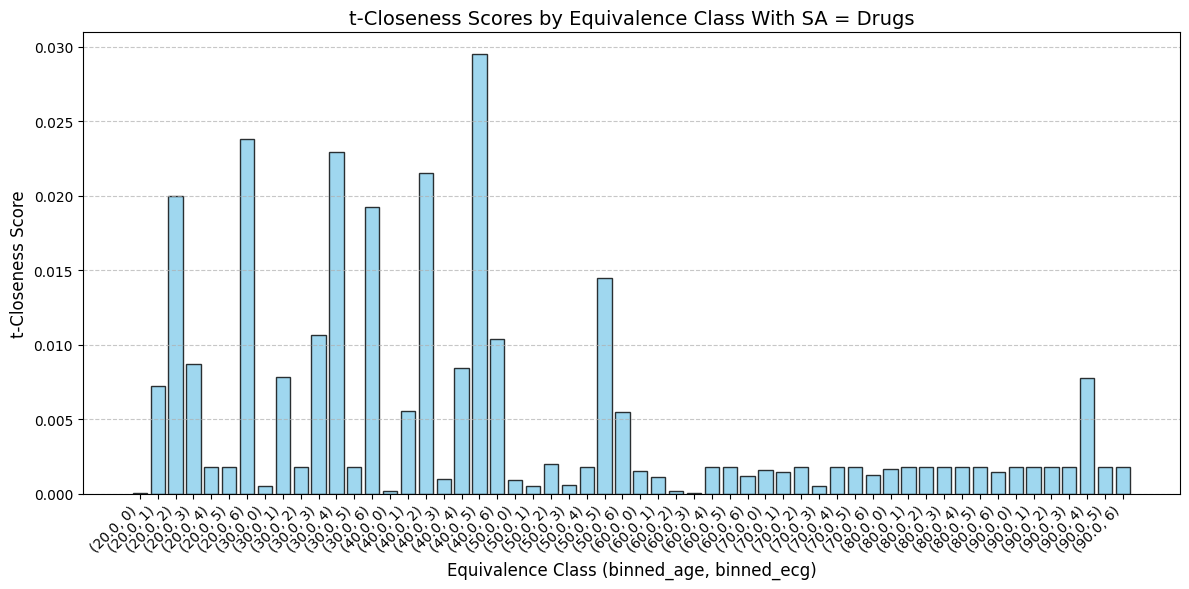

In [72]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance


def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["binned_age", "binned_ecg"]
sensitive_attribute = "drugs"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_sens, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


##Age and Gender With SA Anxiety
# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = Drugs", fontsize=14)
plt.xlabel("Equivalence Class (binned_age, binned_ecg)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Equivalence Class (20.0, 'F', False): t-Closeness Score = 0.0001
Equivalence Class (20.0, 'F', True): t-Closeness Score = 0.0006
Equivalence Class (20.0, 'M', False): t-Closeness Score = 0.0016
Equivalence Class (20.0, 'M', True): t-Closeness Score = 0.0037
Equivalence Class (30.0, 'F', False): t-Closeness Score = 0.0010
Equivalence Class (30.0, 'F', True): t-Closeness Score = 0.0002
Equivalence Class (30.0, 'M', False): t-Closeness Score = 0.0012
Equivalence Class (30.0, 'M', True): t-Closeness Score = 0.0094
Equivalence Class (40.0, 'F', False): t-Closeness Score = 0.0001
Equivalence Class (40.0, 'F', True): t-Closeness Score = 0.0028
Equivalence Class (40.0, 'M', False): t-Closeness Score = 0.0016
Equivalence Class (40.0, 'M', True): t-Closeness Score = 0.0039
Equivalence Class (50.0, 'F', False): t-Closeness Score = 0.0015
Equivalence Class (50.0, 'F', True): t-Closeness Score = 0.0001
Equivalence Class (50.0, 'M', False): t-Closeness Score = 0.0008
Equivalence Class (50.0, 'M', Tr

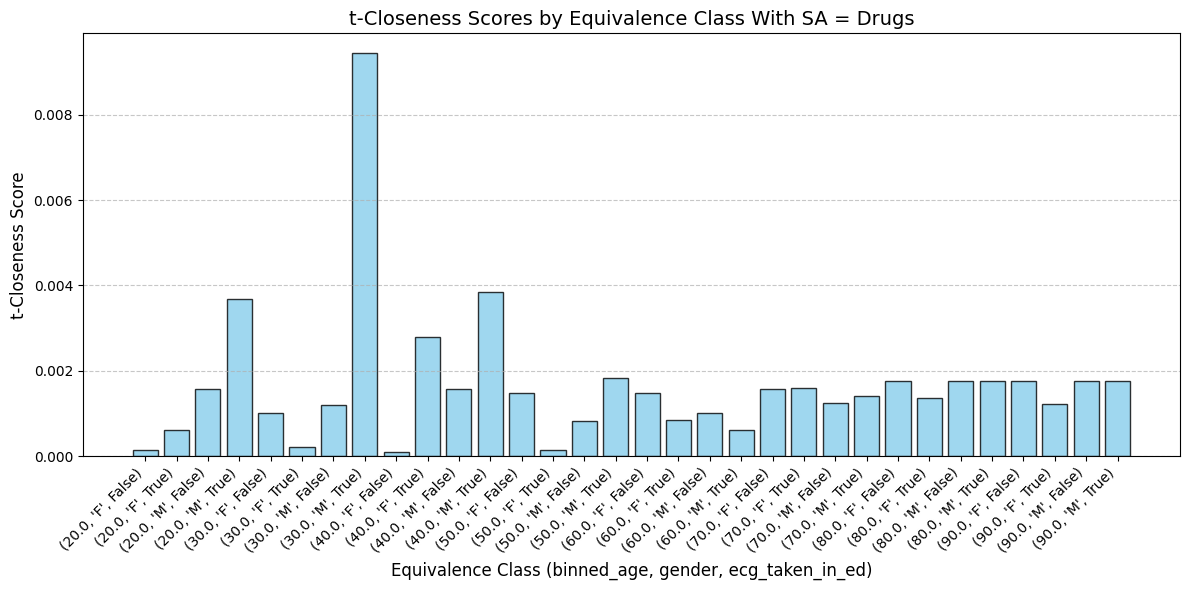

In [73]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance


def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["binned_age", "gender", "ecg_taken_in_ed"]
sensitive_attribute = "drugs"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_sens, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


##Age and Gender With SA Anxiety
# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = Drugs", fontsize=14)
plt.xlabel("Equivalence Class (binned_age, gender, ecg_taken_in_ed)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Equivalence Class (20.0, 'F', False): t-Closeness Score = 0.0013
Equivalence Class (20.0, 'F', True): t-Closeness Score = 0.0045
Equivalence Class (20.0, 'M', False): t-Closeness Score = 0.0002
Equivalence Class (20.0, 'M', True): t-Closeness Score = 0.0020
Equivalence Class (30.0, 'F', False): t-Closeness Score = 0.0010
Equivalence Class (30.0, 'F', True): t-Closeness Score = 0.0023
Equivalence Class (30.0, 'M', False): t-Closeness Score = 0.0013
Equivalence Class (30.0, 'M', True): t-Closeness Score = 0.0003
Equivalence Class (40.0, 'F', False): t-Closeness Score = 0.0017
Equivalence Class (40.0, 'F', True): t-Closeness Score = 0.0027
Equivalence Class (40.0, 'M', False): t-Closeness Score = 0.0017
Equivalence Class (40.0, 'M', True): t-Closeness Score = 0.0028
Equivalence Class (50.0, 'F', False): t-Closeness Score = 0.0013
Equivalence Class (50.0, 'F', True): t-Closeness Score = 0.0015
Equivalence Class (50.0, 'M', False): t-Closeness Score = 0.0020
Equivalence Class (50.0, 'M', Tr

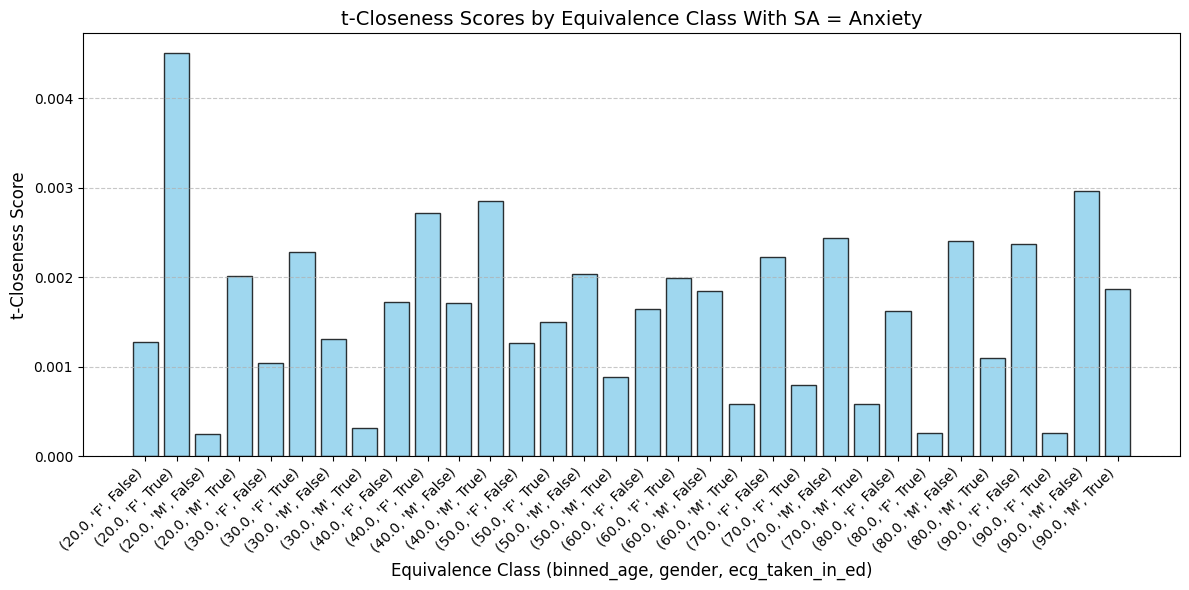

In [74]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance


def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["binned_age", "gender", "ecg_taken_in_ed"]
sensitive_attribute = "anxiety"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_sens, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


##Age and Gender With SA Anxiety
# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = Anxiety", fontsize=14)
plt.xlabel("Equivalence Class (binned_age, gender, ecg_taken_in_ed)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Equivalence Class ('F', 0): t-Closeness Score = 0.0007
Equivalence Class ('F', 1): t-Closeness Score = 0.0016
Equivalence Class ('F', 2): t-Closeness Score = 0.0035
Equivalence Class ('F', 3): t-Closeness Score = 0.0009
Equivalence Class ('F', 4): t-Closeness Score = 0.0087
Equivalence Class ('F', 5): t-Closeness Score = 0.0146
Equivalence Class ('F', 6): t-Closeness Score = 0.0064
Equivalence Class ('M', 0): t-Closeness Score = 0.0014
Equivalence Class ('M', 1): t-Closeness Score = 0.0006
Equivalence Class ('M', 2): t-Closeness Score = 0.0048
Equivalence Class ('M', 3): t-Closeness Score = 0.0002
Equivalence Class ('M', 4): t-Closeness Score = 0.0034
Equivalence Class ('M', 5): t-Closeness Score = 0.0001
Equivalence Class ('M', 6): t-Closeness Score = 0.0021


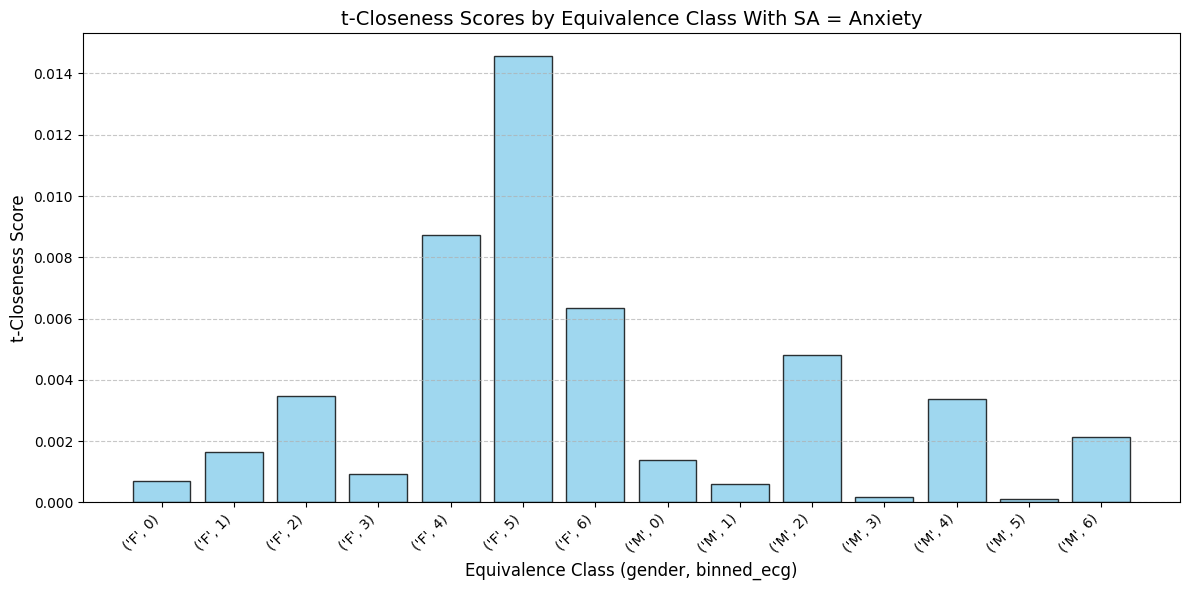

In [75]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance


def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["gender", "binned_ecg"]
sensitive_attribute = "anxiety"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_sens, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


##Age and Gender With SA Anxiety
# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = Anxiety", fontsize=14)
plt.xlabel("Equivalence Class (gender, binned_ecg)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Equivalence Class ('F', 0): t-Closeness Score = 0.0103
Equivalence Class ('F', 1): t-Closeness Score = 0.0027
Equivalence Class ('F', 2): t-Closeness Score = 0.0001
Equivalence Class ('F', 3): t-Closeness Score = 0.0015
Equivalence Class ('F', 4): t-Closeness Score = 0.0042
Equivalence Class ('F', 5): t-Closeness Score = 0.0026
Equivalence Class ('F', 6): t-Closeness Score = 0.0051
Equivalence Class ('M', 0): t-Closeness Score = 0.0003
Equivalence Class ('M', 1): t-Closeness Score = 0.0173
Equivalence Class ('M', 2): t-Closeness Score = 0.0353
Equivalence Class ('M', 3): t-Closeness Score = 0.0193
Equivalence Class ('M', 4): t-Closeness Score = 0.0250
Equivalence Class ('M', 5): t-Closeness Score = 0.0406
Equivalence Class ('M', 6): t-Closeness Score = 0.0270


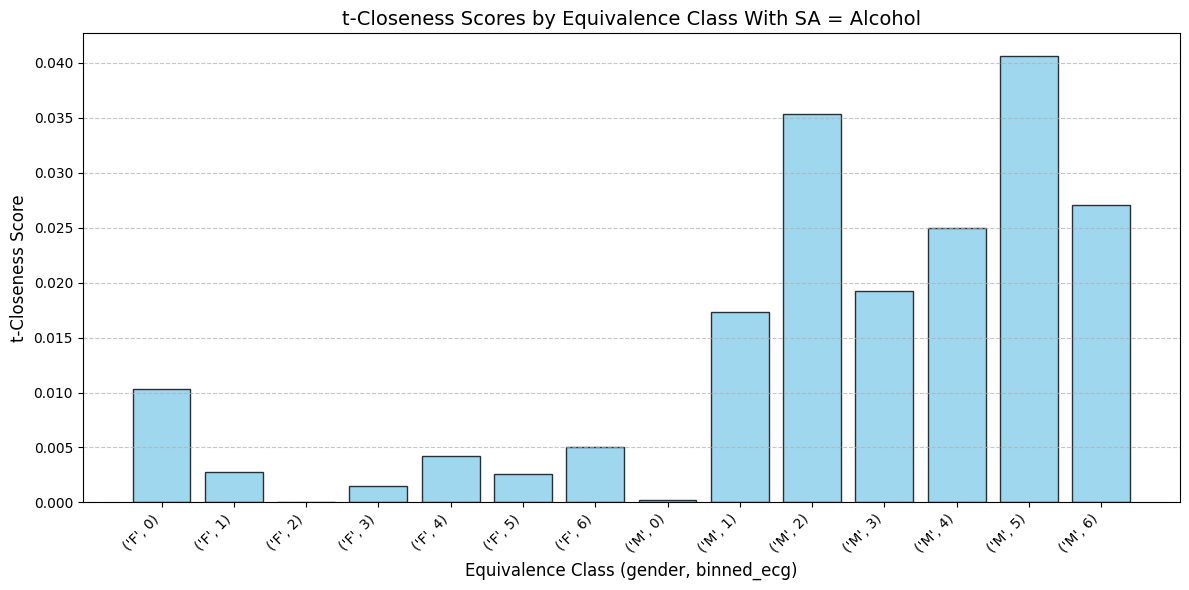

In [76]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance


def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["gender", "binned_ecg"]
sensitive_attribute = "alcohol"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_sens, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


##Age and Gender With SA Anxiety
# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = Alcohol", fontsize=14)
plt.xlabel("Equivalence Class (gender, binned_ecg)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



Equivalence Class ('F', 0): t-Closeness Score = 0.0012
Equivalence Class ('F', 1): t-Closeness Score = 0.0005
Equivalence Class ('F', 2): t-Closeness Score = 0.0032
Equivalence Class ('F', 3): t-Closeness Score = 0.0000
Equivalence Class ('F', 4): t-Closeness Score = 0.0004
Equivalence Class ('F', 5): t-Closeness Score = 0.0053
Equivalence Class ('F', 6): t-Closeness Score = 0.0026
Equivalence Class ('M', 0): t-Closeness Score = 0.0002
Equivalence Class ('M', 1): t-Closeness Score = 0.0020
Equivalence Class ('M', 2): t-Closeness Score = 0.0018
Equivalence Class ('M', 3): t-Closeness Score = 0.0009
Equivalence Class ('M', 4): t-Closeness Score = 0.0010
Equivalence Class ('M', 5): t-Closeness Score = 0.0044
Equivalence Class ('M', 6): t-Closeness Score = 0.0028


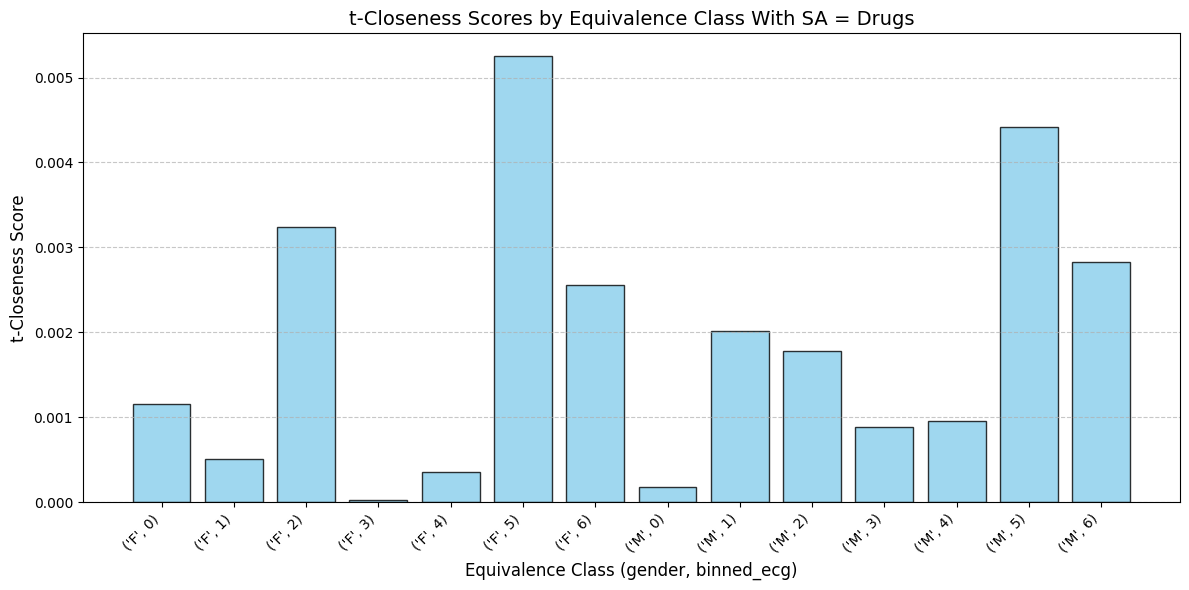

In [77]:
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance


def calculate_t_closeness(df, quasi_identifiers, sensitive_attribute):
    """
    Calculate t-Closeness using Earth Mover's Distance (EMD).

    Parameters:
    - df: pandas DataFrame containing the dataset.
    - quasi_identifiers: list of columns used as quasi-identifiers.
    - sensitive_attribute: column name of the sensitive attribute.

    Returns:
    - A dictionary with equivalence classes and their t-Closeness scores.
    """
    # Calculate overall distribution of the sensitive attribute
    overall_distribution = (
        df[sensitive_attribute].value_counts(normalize=True).sort_index()
    )

    t_closeness_scores = {}

    # Group data by quasi-identifiers
    grouped = df.groupby(quasi_identifiers)

    for group, group_data in grouped:
        # Calculate group distribution
        group_distribution = (
            group_data[sensitive_attribute].value_counts(normalize=True).sort_index()
        )

        # Align distributions to ensure they have the same indices
        all_indices = overall_distribution.index.union(group_distribution.index)
        overall_dist_aligned = overall_distribution.reindex(all_indices, fill_value=0)
        group_dist_aligned = group_distribution.reindex(all_indices, fill_value=0)

        # Calculate Earth Mover's Distance
        emd = wasserstein_distance(overall_dist_aligned.index, group_dist_aligned.index, u_weights=overall_dist_aligned, v_weights=group_dist_aligned)
        t_closeness_scores[group] = emd

    return t_closeness_scores

# Define quasi-identifiers and sensitive attribute
quasi_identifiers = ["gender", "binned_ecg"]
sensitive_attribute = "drugs"

# Calculate t-Closeness scores
t_closeness_results = calculate_t_closeness(df_sens, quasi_identifiers, sensitive_attribute)

# Display results
for eq_class, score in t_closeness_results.items():
    print(f"Equivalence Class {eq_class}: t-Closeness Score = {score:.4f}")


##Age and Gender With SA Anxiety
# Extract equivalence classes and their t-Closeness scores
equivalence_classes = list(t_closeness_results.keys())
scores = list(t_closeness_results.values())

# Convert equivalence classes to strings for labeling
equivalence_class_labels = [str(eq_class) for eq_class in equivalence_classes]

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(equivalence_class_labels, scores, color='skyblue', edgecolor="black", alpha=0.8)
plt.title("t-Closeness Scores by Equivalence Class With SA = Drugs", fontsize=14)
plt.xlabel("Equivalence Class (gender, binned_ecg)", fontsize=12)
plt.ylabel("t-Closeness Score", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



##T closeness Summary and Analysis
Sensitive attributes and respective QIDs t closeness values

SA: anxiety

    binned age, gender = 0.048

    binned age, gender, ecg taken in hosp = 0.0137
    binned age, gender, ecg taken in ed = 0.0049
    binned age, binned ecg = 0.0221
    gender, binned_ecg = 0.0034

SA: alcohol

    binned age, gender = 0.0178
    binned age, gender, ecg taken in hosp = 0.0448
    binned age, gender, ecg taken in ed = 0.0175
    binned age, binned ecg = 0.0934
    gender, binned_ecg = 0.0224

SA: drugs

    binned age, gender = 0.0047
    binned age, gender, ecg taken in hosp = 0.0089
    binned age, gender, ecg taken in ed = 0.006
    binned age, binned ecg = 0.0126
    gender, binned_ecg = 0.0017

When analyzing with 3 QIDs instea of 2, t closeness value is lower, increasing privacy - as expected when introducing more QIDs. More specifically, looking at the set [binned_age, gender, ecg_taken_in_hosp] vs [binned_age, gender, ecg_taken_in_ed] we can see t-closeness is lower for the QID set using ecg_taken_in_ed, indicating that the ecg taken in ed is a more secure QID to release. The binned_ecg QID provides utmost privacy, as shown by the [gender, binned_ecg] QID set displaying extremely low values for t closeness. [binned_age, gender] is the least secure set of QIDs, potentially providing more utility as age and gender are common identifiers that are versatile in the medical field, but allow for facilitated identification.

# Appendix
See this video to see tutorial on MIMIC-IV https://slideslive.com/embed/presentation/38931965

This is an extensive data repository as summarized in this link: https://physionet.org/content/mimiciv/2.2/  In summary, our data resource contains:<br>
<br>*file_name*<br>
800035 non-null path to the waveform
<br>*study_id*<br>
800035 non-null study id within MIMIC-IV-ECG
<br>*subject_id*<br>
800035 non-null subject_id	patient id within MIMIC-IV-ECG
<br>*ecg_time*<br>
800035 non-null ecg_time	time of the waveform collection
<br>*ed_stay_id*<br>
184720 non-null ed_stay_id	ED stay identifier
<br>*ed_hadm_id*<br>
125314 non-null ed_hadm_id	hospital admission identifier sourced from the ED system
<br>*hosp_hadm_id*<br>
298258 non-null hosp_hadm_id	hospital admission identifier
<br>*ed_diag_ed*<br>
800035 non-null ed_diag_ed	CD-10-CM ED discharge diagnoses sourced from the ED system
<br>*ed_diag_hosp*<br>
800035 non-null
<br>*hosp_diag_hosp*<br>
800035 non-null hosp_diag_hosp	ICD-10-CM hospital discharge diagnoses sourced from MIMIC-IV via 'hadm_id'

<br>*all_diag_all*<br>
800035 non-null all_diag_all	'all_diag_hosp' if available otherwise 'ed_diag_ed'
<br>*all_diag_hosp*<br>
800035 non-null all_diag_hosp	unique hospital discharge diagnoses after concatenating 'ed_diag_hosp' and 'hosp_diag_hosp'
<br>*gender*<br>
800035 non-null gender	patient's gender
<br>*age*<br>
795546 non-null age	patient age at the time of ECG recording calculated from 'anchor_age', 'anchor_year', and 'ecg_time'
<br>*anchor_year*<br>
795546 non-null anchor_age	age at 'anchor_year'
<br>*anchor_age*<br>
795546 non-null anchor_year	specified reference year
<br>*dod*<br>
218648 non-null dod	date of death (if applicable)
<br>*ecg_no_within_stay*<br>
800035 non-null ecg_no_within_stay	enumerates ECGs within a given ED/hospital stay
<br>*ecg_taken_in_ed*<br>
800035 non-null ecg_taken_in_ed	boolean variable indicating if the ECG was taken in the ED
<br>*ecg_taken_in_hosp*<br>
800035 non-null ecg_taken_in_hosp	boolean variable indicating if the ECG was taken in the hospital
<br>*ecg_taken_in_ed_or_hosp*<br>
800035 non-null ecg_taken_in_ed_or_hosp	boolean variable indicating if the ECG was taken in ED or hospital (i.e. no outpatient ECG)
<br>*fold* <br>
800035 non-null fold	random fold assignments (without patient overlap) to reproduce benchmarking results from [1]
<br>*strat_fold*<br>
800035 non-null strat_fold	alternative stratified folds using multi-label stratification (applied to 'all_diag_all' truncated to 5 digits and uppropagation along the label tree, gender, age (binned) and outpatient status)

## For further analysis
MIMIC-IV is grouped into two modules: *hosp*, and *icu*. The aim of these modules is to highlight their provenance.

### hosp
The hosp module contains data derived from the hospital wide EHR.

*patients* table provides timing information.
<br>*anchor_age:* patient age in the given anchor_year. If > 89, anchor_age is set to 91
<br>*anchor_year:*   Deidentified year occurring sometime between 2100 - 2200,
<br>*anchor_year_group:*  3Y long date range between 2008 - 2019. These dates allow researchers to infer approximate year of care.
<br>*dod:* Date of death, from hospital records (primary) and state records (matched using a custom rule based linkage algorithm based on name, date of birth, and social security number). Dates of death >1 Y after discharge are censored for deidentification. Thus, the maximum time of follow up for each patient is exactly one year after their last hospital discharge.
<br>*labevents, d_labitems:* laboratory measurements
<br>*microbiologyevents, d_micro:* , microbiology cultures
<br>*poe, poe_detail:* provider orders,
<br>*emar, emar_detail:* medication administration,
<br>*prescriptions, pharmacy:* medication prescription,
<br>*diagnoses_icd, d_icd_diagnoses,procedures_icd, d_icd_procedures, hcpcsevents, d_hcpcs, drgcodes:* hospital billing information,
<br>*omr:* online medical record data
<br>*services:* service related information;
<br>* provider_id:* Deidentified character string which uniquely represents a single care provider.
<br>*admit_provider_id:* provider who admits the patient to the hospital

### icu
Contains data sourced from the clinical information system at the BIDMC: MetaVision (iMDSoft). MetaVision tables were denormalized to create a star schema where the icustays and d_items tables link to a set of data tables all suffixed with "events".

<br>*inputevents:* intravenous and fluid inputs;
<br>*ingredientevents:* ingredients for the aforementioned inputs;
<br>*outputevents:* patient outputs;
<br>*procedureevents:* procedures;
<br>*datetimeevents:* information documented as a date or time;
<br>*chartevents:* other charted information;

All events tables contain a stay_id column allowing identification of the associated ICU patient in icustays, and an itemid column allowing identification of the concept documented in d_items.

Caregiver table contains caregiver_id, a deidentified integer representing the care provider who documented data into the system.

Events tables (chartevents, datetimeevents, ingredientevents, inputevents, outputevents, procedureevents) have a caregiver_id column which links to the caregiver table.

## Playing around - function to test list of codes

In [78]:
#Function to determine which records have/do not have ICD10 codes in an input list []
#https://www.icd10data.com/ICD10CM/Codes
def add_sensitive_flag(dataframe, sensitive_name, list_of_icd10_codes):
    if not list_of_icd10_codes:
        raise ValueError("list_of_icd10_codes must not be empty")

    # Ensure we work with a copy to avoid modifying the original dataframe
    data_frame_with_sensitive = dataframe.copy()

    # Check if all_diag_all column contains lists
    if not all(data_frame_with_sensitive['all_diag_all'].apply(lambda x: isinstance(x, list))):
        raise ValueError("Column 'all_diag_all' must contain lists.")

    # Add the sensitive flag
    data_frame_with_sensitive[sensitive_name] = data_frame_with_sensitive['all_diag_all'].apply(
        lambda x: 1 if any(item in list_of_icd10_codes for item in x) else 0
    )

    return data_frame_with_sensitive

In [79]:
import numpy
import pandas

def Mondrian_allowable_dims(table_partition, quasi_identifiers, k, cut_choice_fcn):
    """A helper function that determines the list of dimensions with allowable cuts.

    Parameters
    ----------
    table_partition : pandas.DataFrame
        The partition on which to determine the dimensions with allowable cuts
    quasi_identifiers : list
        A list containing the set of quasi-identifiers (or dimensions)
    k : int
        The desired k
    cut_choice_fcn : types.FunctionType (lambda data, k: number)
        A function pointer to the cut value selection strategy

    Returns
    -------
    allowable_dims : list
        A list containing the set of dimensions with allowable cuts.
    """

    # We don't know which dimensions will have allowable cuts yet, so we initialize allowable_dims to an empty list
    allowable_dims = []
    for dim_name in quasi_identifiers:
        # For this dimension, the values are
        dim_values = table_partition.loc[:,dim_name]
        # and the cut value is
        dim_boundry_cut = cut_choice_fcn(dim_values.to_list(), k)
        lhs = table_partition.loc[table_partition.loc[:,dim_name] <= dim_boundry_cut,:]
        rhs = table_partition.loc[table_partition.loc[:,dim_name] > dim_boundry_cut,:]
        if lhs.shape[0] >= k and rhs.shape[0] >= k:
            allowable_dims.append(dim_name)
    return allowable_dims

def Mondrian(table_in, quasi_identifiers, k, dim_choice_fcn, cut_choice_fcn):
    """The Mondrian algorithm implementation.

    Parameters
    ----------
    table_in : pandas.DataFrame
        The input table to be generalized
    k : int
        The desired k
    dim_choice_fcn : types.FunctionType (lambda partition, allowable_dims: string)
        A function pointer to the dimension selection strategy
    cut_choice_fcn : types.FunctionType (lambda data, k: number)
        A function pointer to the cut value selection strategy

    Returns
    -------
    table_out : pandas.DataFrame
        The generalized k-Anonymous table
    partition_boundaries : pandas.DataFrame
        A dataframe describing for each partition:
            - the partition boundaries for each quasi-identifier (minimum, maximum), and
            - the partition's final k value

    Raises
    ------
    Exception
        If table_in cannot be made k-Anonymous.
    """

    if table_in.shape[0] < k:
        # Impossible, we can't achieve k-Anonymity, there aren't enough
        # rows in the table!
        raise Exception('It is impossible to k-Anonymize the input table. There are fewer than k rows in the provided table')
    allowable_dims = Mondrian_allowable_dims(table_in, quasi_identifiers, k, cut_choice_fcn)
    if len(allowable_dims) == 0:
        # In this case, there are no more allowable cuts for this partition.
        # Go through the different attributes and change their values by the boundaries of the partition (i.e., sanitize).
        nr_dims = len(quasi_identifiers)
        # initialize the partitiens table
        partition_boundaries = pandas.DataFrame(index=numpy.arange(1), columns=quasi_identifiers + ['k'])
        # get the number of rows for the output table
        nr_rows = table_in.shape[0]
        # initialize the output table
        table_out = pandas.DataFrame(index=table_in.index, columns=table_in.columns)
        # In the output table, set the values of the quasi identifiers according to the partition boundaries
        for dim_name in quasi_identifiers:
            # find the boundaries
            curr_boundaries = (min(table_in.loc[:,dim_name]), max(table_in.loc[:,dim_name]))
            # set the boundries of this dimension in the output variable
            partition_boundaries.loc[:,dim_name] = [curr_boundaries]
            # and set all values of this column to the boundaries in the output table
            # display(numpy.tile(partition_boundaries.loc[:,dim_name],(nr_rows,1)))
            table_out.loc[:,dim_name] = [curr_boundaries]

        # Now that we've worked all quasi-identifiers, we need to copy the values of the sensitive attributes (untouched).
        for dim_name in table_in.columns.difference(quasi_identifiers):
            table_out.loc[:,dim_name] = table_in.loc[:,dim_name]
        # # Package partition boundaries in a list (to prepare it to be appended to other partition boundaries later)
        # partition_boundaries = [partition_boundaries]
        # finally, the output k for this table is the size of the table
        partition_boundaries.loc[:,'k'] = [table_out.shape[0]]
    else:
        # In this case, there is at least one dimension with an allowable cut.
        # Choose a dimension according to our dimension choice function.
        dim = dim_choice_fcn(table_in, allowable_dims)

        # Now we calculate the cur value
        dim_boundry_values = table_in.loc[:,dim]
        dim_boundry_cut = cut_choice_fcn(dim_boundry_values.to_list(), k)

        # The left hand side cut
        lhs = table_in.loc[table_in.loc[:,dim] <= dim_boundry_cut,:]
        lhs_out, lhs_boundaries = Mondrian(lhs, quasi_identifiers, k, dim_choice_fcn, cut_choice_fcn)

        # The right hand side cut
        rhs = table_in.loc[table_in.loc[:,dim] > dim_boundry_cut,:]
        rhs_out, rhs_boundaries = Mondrian(rhs, quasi_identifiers, k, dim_choice_fcn, cut_choice_fcn)

        # Combine the paritions
        table_out = pandas.concat([lhs_out, rhs_out])

        # Combine the boundaries definitions
        partition_boundaries = pandas.concat([lhs_boundaries, rhs_boundaries])

    # Sorting is unnecessary in practice, but doing it so that the results are more easily examinable
    table_out = table_out.sort_values(by=quasi_identifiers).reset_index(drop=True)
    partition_boundaries = partition_boundaries.sort_values(by=quasi_identifiers).reset_index(drop=True)
    return table_out, partition_boundaries

In [80]:
def Mondrian_choose_dim_random(partition, allowable_dims):
    """A dimension choice function choosing a random dimension (with allowable cut) for the next cut.

    Parameters
    ----------
    partition : pandas.DataFrame
        The partition on which to determine dimension for the next cut.
    allowable_dims : list
        A list containing the set of quasi-identifiers (or dimensions) with allowable cuts.
        You may assume that the provided Mondrian implementation will provide this parameter to your function correctly.

    Returns
    -------
    dimension : string
        The name of the quasi-identifier (or dimension) for the chosen cut.
    """

    # Since we select the next dimension randomly from allowable_dims, we ignore partition since it is irrelevant for this behavior
    dimension = allowable_dims[numpy.random.randint(len(allowable_dims))]
    return dimension

In [81]:
def Mondrian_choose_cut_median(data,k):
    """A cut value choice function choosing the median as the value for the next cut.

    Parameters
    ----------
    data : list
        A list containing the values of the chosen dimension from the current partition. This is not a DataFrame,
        this is a list of the values from the chosen column only. That is, in your implementation you may assume that the format
        of this argument is a list of values taken from the column chosen by the dimension choice function.
        E.g., [94705, 94708, 94720, 94708, 94705].
    k : int
        The desired k value.

    Returns
    -------
    dimension : string
        The name of the quasi-identifier (or dimension) for the chosen cut.
    """

    # k here is not needed for median calculation, so we ignore it
    cut_value = numpy.median(data)
    return cut_value

In [82]:
display(df)

,subject_id,ecg_time,ed_diag_ed,ed_diag_hosp,hosp_diag_hosp,all_diag_hosp,all_diag_all,gender,age,dod,ecg_no_within_stay,ecg_taken_in_ed,ecg_taken_in_hosp,ecg_taken_in_ed_or_hosp,binned_age
0,10000032,2180-07-23 08:44:00,"['R4182', 'G9340'],['R4182', 'G9340']","['F319', 'J449', 'B182', 'E871', 'V462', 'I958...","['J449', 'B182', 'E871', 'R197', 'V462', 'R188...","['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...","['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...",F,52.0,2180-09-09,1,True,True,True,50.0
1,10000117,2181-03-04 17:14:00,"['S72092A', 'W1830XA']","['K219', 'F419', 'Z7901', 'Z87891', 'G43909', ...",,"['E7800', 'K219', 'Z87442', 'S72012A', 'I341',...","['E7800', 'K219', 'Z87442', 'S72012A', 'I341',...",F,55.0,None,0,True,False,True,50.0
2,10000285,2159-11-26 14:29:00,['R1012'],,,,['R1012'],M,34.0,None,0,True,False,True,30.0
3,10000560,2189-10-03 12:54:00,,,,,,F,53.0,None,0,False,False,False,50.0
4,10000635,2136-06-19 07:24:00,"['E119', 'R42', 'I10', 'E780']",,"['E119', 'R001', 'I10']","['R001', 'I10', 'E119']","['R001', 'I10', 'E119'],['E119', 'R42', 'I10',...",F,74.0,None,0,True,True,True,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161347,19999733,2152-07-08 21:38:00,"['T781XXA', 'R209', 'G40909', 'X58XXXA']","['T7840XA', 'Y92099']",,"['T7840XA', 'Y92099']","['T7840XA', 'Y92099']",F,19.0,None,0,True,False,True,20.0
161348,19999784,2119-06-18 17:52:00,['R531'],"['M5416', 'C8599', 'D649', 'E440', 'D72819', '...","['Z720', 'C8339', 'Y92239', 'Z6822', 'G9782', ...","['D649', 'D472', 'E440', 'D72819', 'Z6823', 'G...","['D649', 'D472', 'E440', 'D72819', 'Z6823', 'G...",M,57.0,None,0,True,True,True,50.0
161349,19999828,2147-07-29 11:59:00,,,"['F419', 'F1290', 'I8390', 'I10', 'Z7984', 'E1...","['I9581', 'M5430', 'I8390', 'Z7984', 'F1290', ...","['I9581', 'M5430', 'I8390', 'Z7984', 'F1290', ...",F,46.0,None,0,False,True,True,40.0
161350,19999840,2164-07-24 22:31:00,,,"['I69920', 'G40909', 'E785', 'I69959', 'I6350'...","['E785', 'I6350', 'I10', 'F17200', 'G40909', '...","['E785', 'I6350', 'I10', 'F17200', 'G40909', '...",M,58.0,2164-09-17,3,False,True,True,50.0


In [83]:
df.size

2420280

In [84]:
from matplotlib import pyplot
import matplotlib

def visualize_data(table_in, quasi_identifiers, fh=False):
    """A function to visualize the a table on a 2D plane (using exactly 2 quasi-identifiers).

    Parameters
    ----------
    table_in : pandas.DataFrame
        The original table (not the output of Mondrian, but the original non-generalized table).
    quasi_identifiers : list
        A list containing the set of quasi-identifiers.

    Example
    -------
    visualize_data(Lab3_Problem1_demo, ['Zipcode', 'Age'])
    """

    assert len(quasi_identifiers) == 2, 'This function is meant to only be used for visualizing two dimensional partitions'
    if not fh:
        pyplot.subplots(figsize=(12,12))
    # Here are the dimension names to plot
    dim1=quasi_identifiers[0]
    dim2=quasi_identifiers[1]
    # Plot our data points
    pyplot.scatter(table_in.loc[:,dim1], table_in.loc[:,dim2], s=25, c='red')
    # Focus on the relevant area of the plot
    pyplot.xlim([min(table_in.loc[:,dim1])-.5, max(table_in.loc[:,dim1])+.5])
    pyplot.ylim([min(table_in.loc[:,dim2])-.5, max(table_in.loc[:,dim2])+.5])
    # Only the ticks that matter
    pyplot.xticks(numpy.unique(table_in.loc[:,dim1]))
    pyplot.yticks(numpy.unique(table_in.loc[:,dim2]))
    # Add some labels
    pyplot.xlabel(dim1)
    pyplot.ylabel(dim2)
    pyplot.title('Values of quasi-identifiers')

In [85]:
import pandas as pd

columns_to_extract = ['binned_age', 'binned_ecg']
sub_df = df_clean[columns_to_extract]

sub_df = sub_df.drop_duplicates()

top_50_df = sub_df.head(50).reset_index(drop=True)

print(top_50_df)

    binned_age  binned_ecg
0         50.0           1
1         50.0           0
2         30.0           0
3         70.0           0
4         80.0           6
5         70.0           1
6         70.0           6
7         60.0           0
8         40.0           0
9         80.0           1
10        20.0           0
11        80.0           0
12        50.0           6
13        60.0           1
14        70.0           4
15        50.0           3
16        60.0           6
17        80.0           4
18        40.0           3
19        80.0           2
20        70.0           3
21        80.0           3
22        60.0           3
23        40.0           6
24        40.0           1
25        90.0           6
26        70.0           2
27        30.0           2
28        90.0           0
29        50.0           2
30        20.0           1
31        90.0           3
32        30.0           1
33        60.0           4
34        90.0           2
35        40.0           2
3

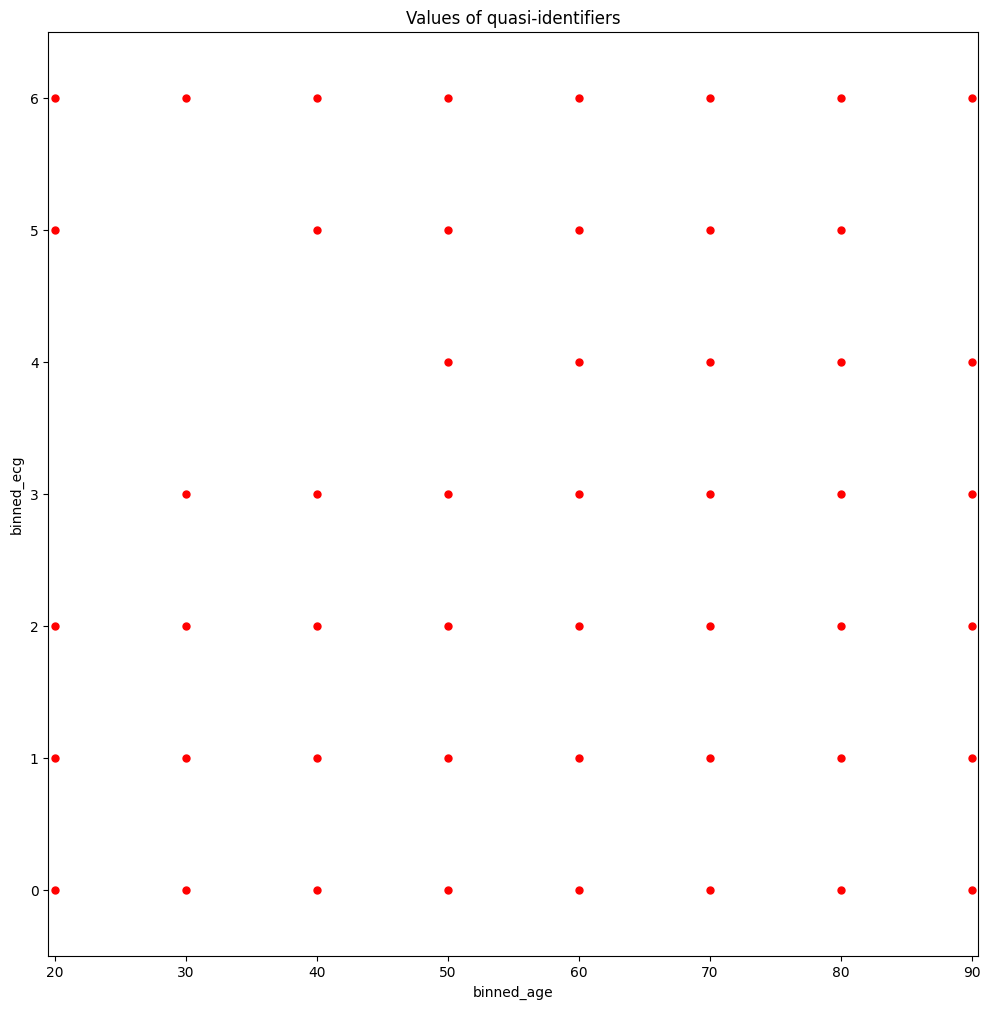

In [86]:
qID = ['binned_age', 'binned_ecg']
visualize_data(top_50_df,qID)

In [87]:
desired_k = 3
tableOut, boundaries = Mondrian(top_50_df, qID, desired_k, Mondrian_choose_dim_random, Mondrian_choose_cut_median)

In [88]:
display(tableOut)

,binned_age,binned_ecg
0,"(20.0, 40.0)","(0, 0)"
1,"(20.0, 40.0)","(0, 0)"
2,"(20.0, 40.0)","(0, 0)"
3,"(20.0, 40.0)","(1, 1)"
4,"(20.0, 40.0)","(1, 1)"
5,"(20.0, 40.0)","(1, 1)"
6,"(20.0, 40.0)","(3, 5)"
7,"(20.0, 40.0)","(3, 5)"
8,"(20.0, 40.0)","(3, 5)"
9,"(20.0, 40.0)","(3, 5)"


In [89]:
for partition_i in range(boundaries.shape[0]):
    display(Markdown(f'Partition number {partition_i+1}:'))
    display(boundaries.iloc[partition_i,:])

Partition number 1:

binned_age    (20.0, 40.0)
binned_ecg          (0, 0)
k                        3
Name: 0, dtype: object

Partition number 2:

binned_age    (20.0, 40.0)
binned_ecg          (1, 1)
k                        3
Name: 1, dtype: object

Partition number 3:

binned_age    (20.0, 40.0)
binned_ecg          (3, 5)
k                        4
Name: 2, dtype: object

Partition number 4:

binned_age    (20.0, 50.0)
binned_ecg          (6, 6)
k                        4
Name: 3, dtype: object

Partition number 5:

binned_age    (20.0, 60.0)
binned_ecg          (2, 2)
k                        5
Name: 4, dtype: object

Partition number 6:

binned_age    (50.0, 50.0)
binned_ecg          (3, 5)
k                        3
Name: 5, dtype: object

Partition number 7:

binned_age    (50.0, 60.0)
binned_ecg          (0, 1)
k                        4
Name: 6, dtype: object

Partition number 8:

binned_age    (60.0, 60.0)
binned_ecg          (3, 6)
k                        4
Name: 7, dtype: object

Partition number 9:

binned_age    (70.0, 70.0)
binned_ecg          (0, 3)
k                        4
Name: 8, dtype: object

Partition number 10:

binned_age    (70.0, 70.0)
binned_ecg          (4, 6)
k                        3
Name: 9, dtype: object

Partition number 11:

binned_age    (80.0, 80.0)
binned_ecg          (0, 3)
k                        4
Name: 10, dtype: object

Partition number 12:

binned_age    (80.0, 80.0)
binned_ecg          (4, 6)
k                        3
Name: 11, dtype: object

Partition number 13:

binned_age    (90.0, 90.0)
binned_ecg          (0, 2)
k                        3
Name: 12, dtype: object

Partition number 14:

binned_age    (90.0, 90.0)
binned_ecg          (3, 6)
k                        3
Name: 13, dtype: object

In [90]:
display(boundaries)

,binned_age,binned_ecg,k
0,"(20.0, 40.0)","(0, 0)",3
1,"(20.0, 40.0)","(1, 1)",3
2,"(20.0, 40.0)","(3, 5)",4
3,"(20.0, 50.0)","(6, 6)",4
4,"(20.0, 60.0)","(2, 2)",5
5,"(50.0, 50.0)","(3, 5)",3
6,"(50.0, 60.0)","(0, 1)",4
7,"(60.0, 60.0)","(3, 6)",4
8,"(70.0, 70.0)","(0, 3)",4
9,"(70.0, 70.0)","(4, 6)",3


In [91]:
def kAnonymity_Analyze(data, qID):
    eqv_classes = data.groupby(qID).apply(lambda x: len(x)).reset_index(name='k')
    return min(eqv_classes.k), eqv_classes

qID = ['binned_age', 'binned_ecg']
[actual_k,ec_report] = kAnonymity_Analyze(tableOut, qID)
display(ec_report)
display(Markdown(f'Yielding k = {actual_k}'))

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_20788\983034028.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eqv_classes = data.groupby(qID).apply(lambda x: len(x)).reset_index(name='k')


,binned_age,binned_ecg,k
0,"(20.0, 40.0)","(0, 0)",3
1,"(20.0, 40.0)","(1, 1)",3
2,"(20.0, 40.0)","(3, 5)",4
3,"(20.0, 50.0)","(6, 6)",4
4,"(20.0, 60.0)","(2, 2)",5
5,"(50.0, 50.0)","(3, 5)",3
6,"(50.0, 60.0)","(0, 1)",4
7,"(60.0, 60.0)","(3, 6)",4
8,"(70.0, 70.0)","(0, 3)",4
9,"(70.0, 70.0)","(4, 6)",3


Yielding k = 3

In [92]:
def visualize_Mondrian(table_in, quasi_identifiers, boundaries):
    """A function to visualize the outcome of the Mondrian algorithm

    Parameters
    ----------
    table_in : pandas.DataFrame
        The original table (not the output of Mondrian, but the original non-generalized table).
    quasi_identifiers : list
        A list containing the set of quasi-identifiers.
    boundaries : pandas.DataFrame
        The second output of the function Mondrian() containing the boundaries for each partition
    """

    assert len(quasi_identifiers) == 2, 'This function is meant to only be used for visualizing two dimensional partitions'
    # Start a figure
    fh, ax= pyplot.subplots(figsize=(12,12))


    # Calculate the min distances between datapoints in each dimension
    dim_granularities = numpy.full((table_in.shape[1],1), numpy.nan)
    for dim in range(2):
        dim_unique = numpy.unique(table_in.iloc[:,dim])
        dim_granularities[dim] = min(numpy.diff(dim_unique))/2


    # Generate the colors for the boundary boxes
    cols = pyplot.cm.gray(numpy.linspace(0,1,len(boundaries)), alpha=1)

    # For each boundary
    for boundary_i in range(0,len(boundaries)):
        # Get the current boundary dimensions
        curr_boundary = boundaries.loc[boundary_i,quasi_identifiers]

        # These are the x,y coordinates of the bottom left corner
        x = curr_boundary.iloc[0][0]-dim_granularities[0]
        y = curr_boundary.iloc[1][0]-dim_granularities[1]

        # These are the width and height of the box
        w = curr_boundary.iloc[0][1] - x + dim_granularities[0]
        h = curr_boundary.iloc[1][1] - y + dim_granularities[1]

        # Plot the box
        curr_ec = matplotlib.patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='red', facecolor=cols[boundary_i])

        ax.add_patch(curr_ec)

        pyplot.text(x+dim_granularities[0]*0.5, y+h/2+dim_granularities[1]*0, boundaries.loc[boundary_i,'k'] ,horizontalalignment='center', verticalalignment='center', size=10, c='red', bbox=dict(boxstyle='square,pad=0', facecolor='blue', alpha=0))

    visualize_data(table_in, quasi_identifiers, fh)
    pyplot.show()



In [95]:
#Function to determine which records have/do not have ICD10 codes in an input list []
#https://www.icd10data.com/ICD10CM/Codes
def add_sensitive_flag(dataframe, sensitive_name, list_of_icd10_codes):
    if not list_of_icd10_codes:
        raise ValueError("list_of_icd10_codes must not be empty")

    # Ensure we work with a copy to avoid modifying the original dataframe
    data_frame_with_sensitive = dataframe.copy()

    # Check if all_diag_all column contains lists
    if not all(data_frame_with_sensitive['all_diag_all'].apply(lambda x: isinstance(x, list))):
        raise ValueError("Column 'all_diag_all' must contain lists.")

    # Add the sensitive flag
    data_frame_with_sensitive[sensitive_name] = data_frame_with_sensitive['all_diag_all'].apply(
        lambda x: 1 if any(item in list_of_icd10_codes for item in x) else 0
    )

    return data_frame_with_sensitive

In [96]:
import numpy
import pandas

def Mondrian_allowable_dims(table_partition, quasi_identifiers, k, cut_choice_fcn):
    """A helper function that determines the list of dimensions with allowable cuts.
    
    Parameters
    ----------
    table_partition : pandas.DataFrame
        The partition on which to determine the dimensions with allowable cuts
    quasi_identifiers : list
        A list containing the set of quasi-identifiers (or dimensions)
    k : int
        The desired k
    cut_choice_fcn : types.FunctionType (lambda data, k: number)
        A function pointer to the cut value selection strategy
    
    Returns
    -------
    allowable_dims : list
        A list containing the set of dimensions with allowable cuts.
    """
    
    # We don't know which dimensions will have allowable cuts yet, so we initialize allowable_dims to an empty list
    allowable_dims = []
    for dim_name in quasi_identifiers:
        # For this dimension, the values are
        dim_values = table_partition.loc[:,dim_name]
        # and the cut value is
        dim_boundry_cut = cut_choice_fcn(dim_values.to_list(), k)
        lhs = table_partition.loc[table_partition.loc[:,dim_name] <= dim_boundry_cut,:]
        rhs = table_partition.loc[table_partition.loc[:,dim_name] > dim_boundry_cut,:]
        if lhs.shape[0] >= k and rhs.shape[0] >= k:
            allowable_dims.append(dim_name)
    return allowable_dims

def Mondrian(table_in, quasi_identifiers, k, dim_choice_fcn, cut_choice_fcn):
    """The Mondrian algorithm implementation.
    
    Parameters
    ----------
    table_in : pandas.DataFrame
        The input table to be generalized
    k : int
        The desired k
    dim_choice_fcn : types.FunctionType (lambda partition, allowable_dims: string)
        A function pointer to the dimension selection strategy
    cut_choice_fcn : types.FunctionType (lambda data, k: number)
        A function pointer to the cut value selection strategy
    
    Returns
    -------
    table_out : pandas.DataFrame
        The generalized k-Anonymous table
    partition_boundaries : pandas.DataFrame
        A dataframe describing for each partition:
            - the partition boundaries for each quasi-identifier (minimum, maximum), and
            - the partition's final k value
    
    Raises
    ------
    Exception
        If table_in cannot be made k-Anonymous.
    """
    
    if table_in.shape[0] < k:
        # Impossible, we can't achieve k-Anonymity, there aren't enough
        # rows in the table!
        raise Exception('It is impossible to k-Anonymize the input table. There are fewer than k rows in the provided table')
    allowable_dims = Mondrian_allowable_dims(table_in, quasi_identifiers, k, cut_choice_fcn)
    if len(allowable_dims) == 0:
        # In this case, there are no more allowable cuts for this partition.
        # Go through the different attributes and change their values by the boundaries of the partition (i.e., sanitize).
        nr_dims = len(quasi_identifiers)
        # initialize the partitiens table
        partition_boundaries = pandas.DataFrame(index=numpy.arange(1), columns=quasi_identifiers + ['k'])
        # get the number of rows for the output table
        nr_rows = table_in.shape[0]
        # initialize the output table
        table_out = pandas.DataFrame(index=table_in.index, columns=table_in.columns)
        # In the output table, set the values of the quasi identifiers according to the partition boundaries
        for dim_name in quasi_identifiers:
            # find the boundaries
            curr_boundaries = (min(table_in.loc[:,dim_name]), max(table_in.loc[:,dim_name]))
            # set the boundries of this dimension in the output variable
            partition_boundaries.loc[:,dim_name] = [curr_boundaries]
            # and set all values of this column to the boundaries in the output table
            # display(numpy.tile(partition_boundaries.loc[:,dim_name],(nr_rows,1)))
            table_out.loc[:,dim_name] = [curr_boundaries]
            
        # Now that we've worked all quasi-identifiers, we need to copy the values of the sensitive attributes (untouched).
        for dim_name in table_in.columns.difference(quasi_identifiers):
            table_out.loc[:,dim_name] = table_in.loc[:,dim_name]
        # # Package partition boundaries in a list (to prepare it to be appended to other partition boundaries later)
        # partition_boundaries = [partition_boundaries]
        # finally, the output k for this table is the size of the table
        partition_boundaries.loc[:,'k'] = [table_out.shape[0]]
    else:
        # In this case, there is at least one dimension with an allowable cut.
        # Choose a dimension according to our dimension choice function.
        dim = dim_choice_fcn(table_in, allowable_dims)
        
        # Now we calculate the cur value
        dim_boundry_values = table_in.loc[:,dim]
        dim_boundry_cut = cut_choice_fcn(dim_boundry_values.to_list(), k)
        
        # The left hand side cut
        lhs = table_in.loc[table_in.loc[:,dim] <= dim_boundry_cut,:]
        lhs_out, lhs_boundaries = Mondrian(lhs, quasi_identifiers, k, dim_choice_fcn, cut_choice_fcn)
        
        # The right hand side cut
        rhs = table_in.loc[table_in.loc[:,dim] > dim_boundry_cut,:]
        rhs_out, rhs_boundaries = Mondrian(rhs, quasi_identifiers, k, dim_choice_fcn, cut_choice_fcn)
        
        # Combine the paritions
        table_out = pandas.concat([lhs_out, rhs_out])
        
        # Combine the boundaries definitions
        partition_boundaries = pandas.concat([lhs_boundaries, rhs_boundaries])
             
    # Sorting is unnecessary in practice, but doing it so that the results are more easily examinable
    table_out = table_out.sort_values(by=quasi_identifiers).reset_index(drop=True)
    partition_boundaries = partition_boundaries.sort_values(by=quasi_identifiers).reset_index(drop=True)
    return table_out, partition_boundaries

In [97]:
def Mondrian_choose_dim_random(partition, allowable_dims):
    """A dimension choice function choosing a random dimension (with allowable cut) for the next cut.
    
    Parameters
    ----------
    partition : pandas.DataFrame
        The partition on which to determine dimension for the next cut.
    allowable_dims : list
        A list containing the set of quasi-identifiers (or dimensions) with allowable cuts.
        You may assume that the provided Mondrian implementation will provide this parameter to your function correctly.
    
    Returns
    -------
    dimension : string
        The name of the quasi-identifier (or dimension) for the chosen cut.
    """
    
    # Since we select the next dimension randomly from allowable_dims, we ignore partition since it is irrelevant for this behavior
    dimension = allowable_dims[numpy.random.randint(len(allowable_dims))]
    return dimension

In [98]:
def Mondrian_choose_cut_median(data,k):
    """A cut value choice function choosing the median as the value for the next cut.
    
    Parameters
    ----------
    data : list
        A list containing the values of the chosen dimension from the current partition. This is not a DataFrame,
        this is a list of the values from the chosen column only. That is, in your implementation you may assume that the format
        of this argument is a list of values taken from the column chosen by the dimension choice function.
        E.g., [94705, 94708, 94720, 94708, 94705].
    k : int
        The desired k value.
    
    Returns
    -------
    dimension : string
        The name of the quasi-identifier (or dimension) for the chosen cut.
    """
    
    # k here is not needed for median calculation, so we ignore it
    cut_value = numpy.median(data)
    return cut_value

In [99]:
display(df)

,subject_id,ecg_time,ed_diag_ed,ed_diag_hosp,hosp_diag_hosp,all_diag_hosp,all_diag_all,gender,age,dod,ecg_no_within_stay,ecg_taken_in_ed,ecg_taken_in_hosp,ecg_taken_in_ed_or_hosp,binned_age
0,10000032,2180-07-23 08:44:00,"['R4182', 'G9340'],['R4182', 'G9340']","['F319', 'J449', 'B182', 'E871', 'V462', 'I958...","['J449', 'B182', 'E871', 'R197', 'V462', 'R188...","['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...","['K7469', 'E871', 'R64', 'E875', 'I9581', 'J44...",F,52.0,2180-09-09,1,True,True,True,50.0
1,10000117,2181-03-04 17:14:00,"['S72092A', 'W1830XA']","['K219', 'F419', 'Z7901', 'Z87891', 'G43909', ...",,"['E7800', 'K219', 'Z87442', 'S72012A', 'I341',...","['E7800', 'K219', 'Z87442', 'S72012A', 'I341',...",F,55.0,None,0,True,False,True,50.0
2,10000285,2159-11-26 14:29:00,['R1012'],,,,['R1012'],M,34.0,None,0,True,False,True,30.0
3,10000560,2189-10-03 12:54:00,,,,,,F,53.0,None,0,False,False,False,50.0
4,10000635,2136-06-19 07:24:00,"['E119', 'R42', 'I10', 'E780']",,"['E119', 'R001', 'I10']","['R001', 'I10', 'E119']","['R001', 'I10', 'E119'],['E119', 'R42', 'I10',...",F,74.0,None,0,True,True,True,70.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161347,19999733,2152-07-08 21:38:00,"['T781XXA', 'R209', 'G40909', 'X58XXXA']","['T7840XA', 'Y92099']",,"['T7840XA', 'Y92099']","['T7840XA', 'Y92099']",F,19.0,None,0,True,False,True,20.0
161348,19999784,2119-06-18 17:52:00,['R531'],"['M5416', 'C8599', 'D649', 'E440', 'D72819', '...","['Z720', 'C8339', 'Y92239', 'Z6822', 'G9782', ...","['D649', 'D472', 'E440', 'D72819', 'Z6823', 'G...","['D649', 'D472', 'E440', 'D72819', 'Z6823', 'G...",M,57.0,None,0,True,True,True,50.0
161349,19999828,2147-07-29 11:59:00,,,"['F419', 'F1290', 'I8390', 'I10', 'Z7984', 'E1...","['I9581', 'M5430', 'I8390', 'Z7984', 'F1290', ...","['I9581', 'M5430', 'I8390', 'Z7984', 'F1290', ...",F,46.0,None,0,False,True,True,40.0
161350,19999840,2164-07-24 22:31:00,,,"['I69920', 'G40909', 'E785', 'I69959', 'I6350'...","['E785', 'I6350', 'I10', 'F17200', 'G40909', '...","['E785', 'I6350', 'I10', 'F17200', 'G40909', '...",M,58.0,2164-09-17,3,False,True,True,50.0


In [100]:
from matplotlib import pyplot
import matplotlib

def visualize_data(table_in, quasi_identifiers, fh=False):
    """A function to visualize the a table on a 2D plane (using exactly 2 quasi-identifiers).
    
    Parameters
    ----------
    table_in : pandas.DataFrame
        The original table (not the output of Mondrian, but the original non-generalized table).
    quasi_identifiers : list
        A list containing the set of quasi-identifiers.
    
    Example
    -------
    visualize_data(Lab3_Problem1_demo, ['Zipcode', 'Age'])
    """
    
    assert len(quasi_identifiers) == 2, 'This function is meant to only be used for visualizing two dimensional partitions'
    if not fh:
        pyplot.subplots(figsize=(12,12))
    # Here are the dimension names to plot
    dim1=quasi_identifiers[0]
    dim2=quasi_identifiers[1]
    # Plot our data points
    pyplot.scatter(table_in.loc[:,dim1], table_in.loc[:,dim2], s=25, c='red')
    # Focus on the relevant area of the plot
    pyplot.xlim([min(table_in.loc[:,dim1])-.5, max(table_in.loc[:,dim1])+.5])
    pyplot.ylim([min(table_in.loc[:,dim2])-.5, max(table_in.loc[:,dim2])+.5])
    # Only the ticks that matter
    pyplot.xticks(numpy.unique(table_in.loc[:,dim1]))
    pyplot.yticks(numpy.unique(table_in.loc[:,dim2]))
    # Add some labels
    pyplot.xlabel(dim1)
    pyplot.ylabel(dim2)
    pyplot.title('Values of quasi-identifiers')

In [101]:
import pandas as pd

columns_to_extract = ['binned_age', 'binned_ecg'] 
sub_df = df_clean[columns_to_extract]

#sub_df = sub_df.drop_duplicates()

#top_50_df = sub_df.head(50).reset_index(drop=True)

print(sub_df)

        binned_age  binned_ecg
0             50.0           1
1             50.0           0
2             30.0           0
3             50.0           0
4             70.0           0
...            ...         ...
161347        20.0           0
161348        50.0           0
161349        40.0           0
161350        50.0           3
161351        50.0           1

[159608 rows x 2 columns]


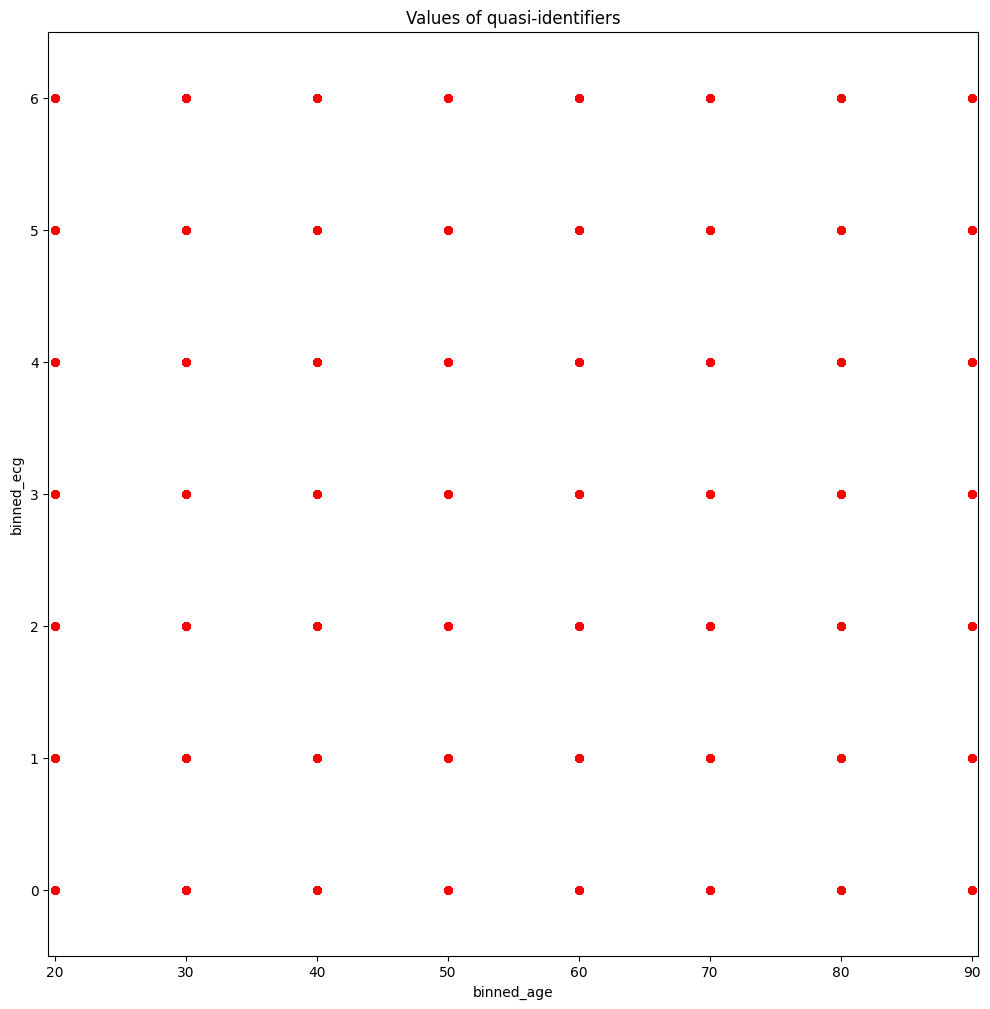

In [102]:
qID = ['binned_age', 'binned_ecg']
visualize_data(sub_df,qID)

In [104]:
desired_k = 80
tableOut, boundaries = Mondrian(sub_df, qID, desired_k, Mondrian_choose_dim_random, Mondrian_choose_cut_median)
display(tableOut)

,binned_age,binned_ecg
0,"(20.0, 20.0)","(0, 0)"
1,"(20.0, 20.0)","(0, 0)"
2,"(20.0, 20.0)","(0, 0)"
3,"(20.0, 20.0)","(0, 0)"
4,"(20.0, 20.0)","(0, 0)"
...,...,...
159603,"(90.0, 90.0)","(4, 6)"
159604,"(90.0, 90.0)","(4, 6)"
159605,"(90.0, 90.0)","(4, 6)"
159606,"(90.0, 90.0)","(4, 6)"


In [105]:
for partition_i in range(boundaries.shape[0]):
    display(Markdown(f'Partition number {partition_i+1}:'))
    display(boundaries.iloc[partition_i,:])

Partition number 1:

binned_age    (20.0, 20.0)
binned_ecg          (0, 0)
k                    16288
Name: 0, dtype: object

Partition number 2:

binned_age    (20.0, 30.0)
binned_ecg          (1, 1)
k                     2792
Name: 1, dtype: object

Partition number 3:

binned_age    (20.0, 40.0)
binned_ecg          (2, 2)
k                      550
Name: 2, dtype: object

Partition number 4:

binned_age    (20.0, 50.0)
binned_ecg          (3, 6)
k                     8808
Name: 3, dtype: object

Partition number 5:

binned_age    (30.0, 30.0)
binned_ecg          (0, 0)
k                    12599
Name: 4, dtype: object

Partition number 6:

binned_age    (40.0, 40.0)
binned_ecg          (0, 0)
k                    14822
Name: 5, dtype: object

Partition number 7:

binned_age    (40.0, 40.0)
binned_ecg          (1, 1)
k                     2469
Name: 6, dtype: object

Partition number 8:

binned_age    (50.0, 50.0)
binned_ecg          (0, 0)
k                    20608
Name: 7, dtype: object

Partition number 9:

binned_age    (50.0, 50.0)
binned_ecg          (1, 1)
k                     3991
Name: 8, dtype: object

Partition number 10:

binned_age    (50.0, 50.0)
binned_ecg          (2, 2)
k                      531
Name: 9, dtype: object

Partition number 11:

binned_age    (60.0, 60.0)
binned_ecg          (0, 0)
k                    18891
Name: 10, dtype: object

Partition number 12:

binned_age    (60.0, 60.0)
binned_ecg          (1, 1)
k                     4457
Name: 11, dtype: object

Partition number 13:

binned_age    (60.0, 60.0)
binned_ecg          (2, 3)
k                     2358
Name: 12, dtype: object

Partition number 14:

binned_age    (60.0, 60.0)
binned_ecg          (4, 6)
k                     4714
Name: 13, dtype: object

Partition number 15:

binned_age    (70.0, 70.0)
binned_ecg          (0, 0)
k                    13065
Name: 14, dtype: object

Partition number 16:

binned_age    (70.0, 70.0)
binned_ecg          (1, 1)
k                     3620
Name: 15, dtype: object

Partition number 17:

binned_age    (70.0, 70.0)
binned_ecg          (2, 3)
k                     2139
Name: 16, dtype: object

Partition number 18:

binned_age    (70.0, 70.0)
binned_ecg          (4, 6)
k                     4590
Name: 17, dtype: object

Partition number 19:

binned_age    (80.0, 80.0)
binned_ecg          (0, 0)
k                     9009
Name: 18, dtype: object

Partition number 20:

binned_age    (80.0, 80.0)
binned_ecg          (1, 1)
k                     2827
Name: 19, dtype: object

Partition number 21:

binned_age    (80.0, 80.0)
binned_ecg          (2, 3)
k                     1642
Name: 20, dtype: object

Partition number 22:

binned_age    (80.0, 80.0)
binned_ecg          (4, 6)
k                     3510
Name: 21, dtype: object

Partition number 23:

binned_age    (90.0, 90.0)
binned_ecg          (0, 0)
k                     3116
Name: 22, dtype: object

Partition number 24:

binned_age    (90.0, 90.0)
binned_ecg          (1, 1)
k                      880
Name: 23, dtype: object

Partition number 25:

binned_age    (90.0, 90.0)
binned_ecg          (2, 3)
k                      471
Name: 24, dtype: object

Partition number 26:

binned_age    (90.0, 90.0)
binned_ecg          (4, 6)
k                      861
Name: 25, dtype: object

In [106]:
display(boundaries)

,binned_age,binned_ecg,k
0,"(20.0, 20.0)","(0, 0)",16288
1,"(20.0, 30.0)","(1, 1)",2792
2,"(20.0, 40.0)","(2, 2)",550
3,"(20.0, 50.0)","(3, 6)",8808
4,"(30.0, 30.0)","(0, 0)",12599
5,"(40.0, 40.0)","(0, 0)",14822
6,"(40.0, 40.0)","(1, 1)",2469
7,"(50.0, 50.0)","(0, 0)",20608
8,"(50.0, 50.0)","(1, 1)",3991
9,"(50.0, 50.0)","(2, 2)",531


In [107]:
def kAnonymity_Analyze(data, qID):
    eqv_classes = data.groupby(qID).apply(lambda x: len(x)).reset_index(name='k')    
    return min(eqv_classes.k), eqv_classes

qID = ['binned_age', 'binned_ecg']
[actual_k,ec_report] = kAnonymity_Analyze(tableOut, qID)
display(ec_report)
display(Markdown(f'Yielding k = {actual_k}'))

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_20788\3056391049.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eqv_classes = data.groupby(qID).apply(lambda x: len(x)).reset_index(name='k')


,binned_age,binned_ecg,k
0,"(20.0, 20.0)","(0, 0)",16288
1,"(20.0, 30.0)","(1, 1)",2792
2,"(20.0, 40.0)","(2, 2)",550
3,"(20.0, 50.0)","(3, 6)",8808
4,"(30.0, 30.0)","(0, 0)",12599
5,"(40.0, 40.0)","(0, 0)",14822
6,"(40.0, 40.0)","(1, 1)",2469
7,"(50.0, 50.0)","(0, 0)",20608
8,"(50.0, 50.0)","(1, 1)",3991
9,"(50.0, 50.0)","(2, 2)",531


Yielding k = 471

In [108]:
def visualize_Mondrian(table_in, quasi_identifiers, boundaries):
    """A function to visualize the outcome of the Mondrian algorithm
    
    Parameters
    ----------
    table_in : pandas.DataFrame
        The original table (not the output of Mondrian, but the original non-generalized table).
    quasi_identifiers : list
        A list containing the set of quasi-identifiers.
    boundaries : pandas.DataFrame
        The second output of the function Mondrian() containing the boundaries for each partition
    """
    
    assert len(quasi_identifiers) == 2, 'This function is meant to only be used for visualizing two dimensional partitions'
    # Start a figure
    fh, ax= pyplot.subplots(figsize=(12,12))
    
    
    # Calculate the min distances between datapoints in each dimension
    dim_granularities = numpy.full((table_in.shape[1],1), numpy.nan)
    for dim in range(2):
        dim_unique = numpy.unique(table_in.iloc[:,dim])
        dim_granularities[dim] = min(numpy.diff(dim_unique))/2
        

    # Generate the colors for the boundary boxes
    cols = pyplot.cm.gray(numpy.linspace(0,1,len(boundaries)), alpha=1)
    
    # For each boundary
    for boundary_i in range(0,len(boundaries)):
        # Get the current boundary dimensions
        curr_boundary = boundaries.loc[boundary_i,quasi_identifiers]
        
        # These are the x,y coordinates of the bottom left corner
        x = curr_boundary.iloc[0][0]-dim_granularities[0]
        y = curr_boundary.iloc[1][0]-dim_granularities[1]
        
        # These are the width and height of the box
        w = curr_boundary.iloc[0][1] - x + dim_granularities[0]
        h = curr_boundary.iloc[1][1] - y + dim_granularities[1]
        
        # Plot the box
        curr_ec = matplotlib.patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='red', facecolor=cols[boundary_i])
        
        ax.add_patch(curr_ec)
        
        pyplot.text(x+dim_granularities[0]*0.5, y+h/2+dim_granularities[1]*0, boundaries.loc[boundary_i,'k'] ,horizontalalignment='center', verticalalignment='center', size=10, c='red', bbox=dict(boxstyle='square,pad=0', facecolor='blue', alpha=0))
        
    visualize_data(table_in, quasi_identifiers, fh)
    pyplot.show()

    

In [109]:
def Mondrian_choose_dim_highest_distinct(table_partition, allowable_dims):
    distinct_counts = {
        dim: len(set(table_partition[dim]))
        for dim in allowable_dims
    }

    # Sort by the number of distinct values (descending) and by allowable_dims order (if tie)
    sorted_dims = sorted(
        distinct_counts.keys(),
        key=lambda dim: (-distinct_counts[dim], allowable_dims.index(dim))
    )

    # Return the first dimension from the sorted list
    return sorted_dims[0]

In [110]:
def Mondrian_choose_cut_first_split(data,k):
    sorted_data = numpy.sort(data)
    
    # Check for a valid cut point
    n = len(sorted_data)
    for i in range(n):
        
        # Ensure both partitions meet the size requirement
        if i + 1 >= k and n - (i + 1) >= k:
            return sorted_data[i]
    
    # Return np.nan if no valid cut exists
    return numpy.nan

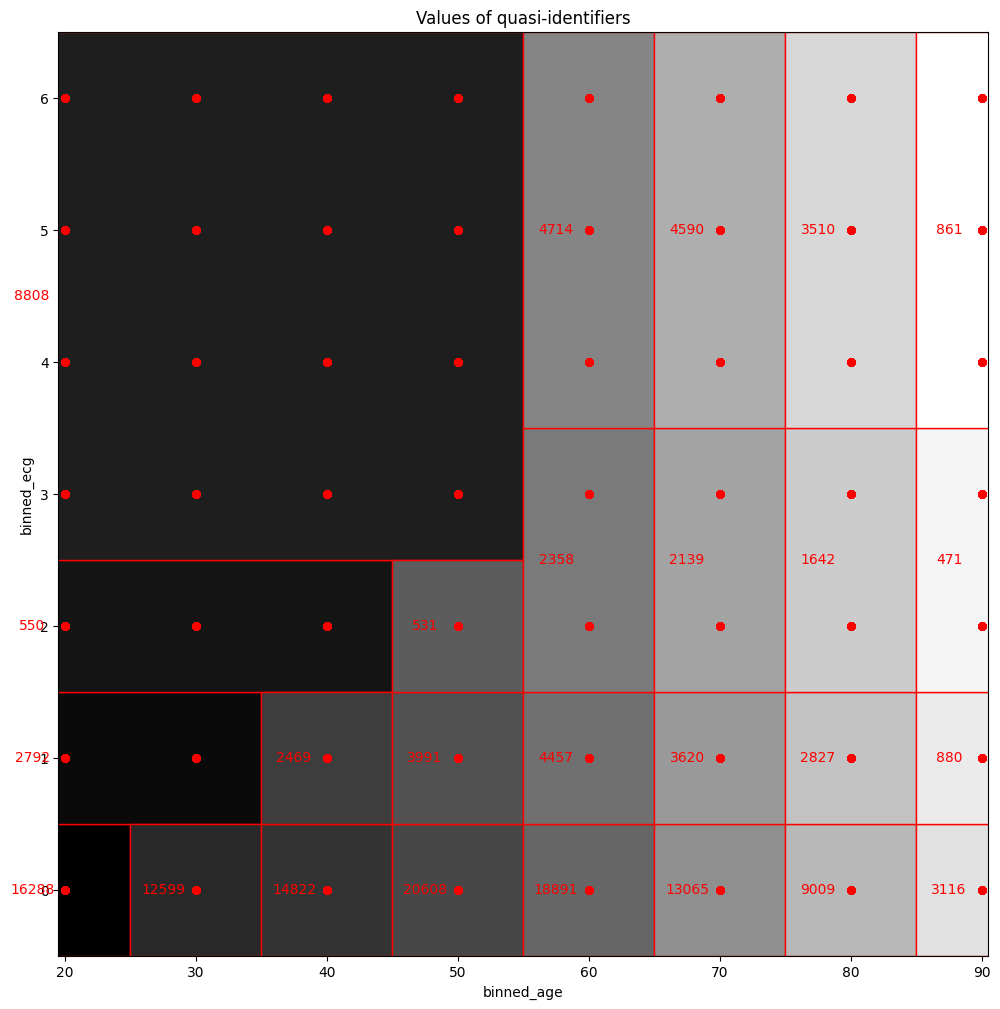

In [111]:
visualize_Mondrian(sub_df, qID, boundaries)

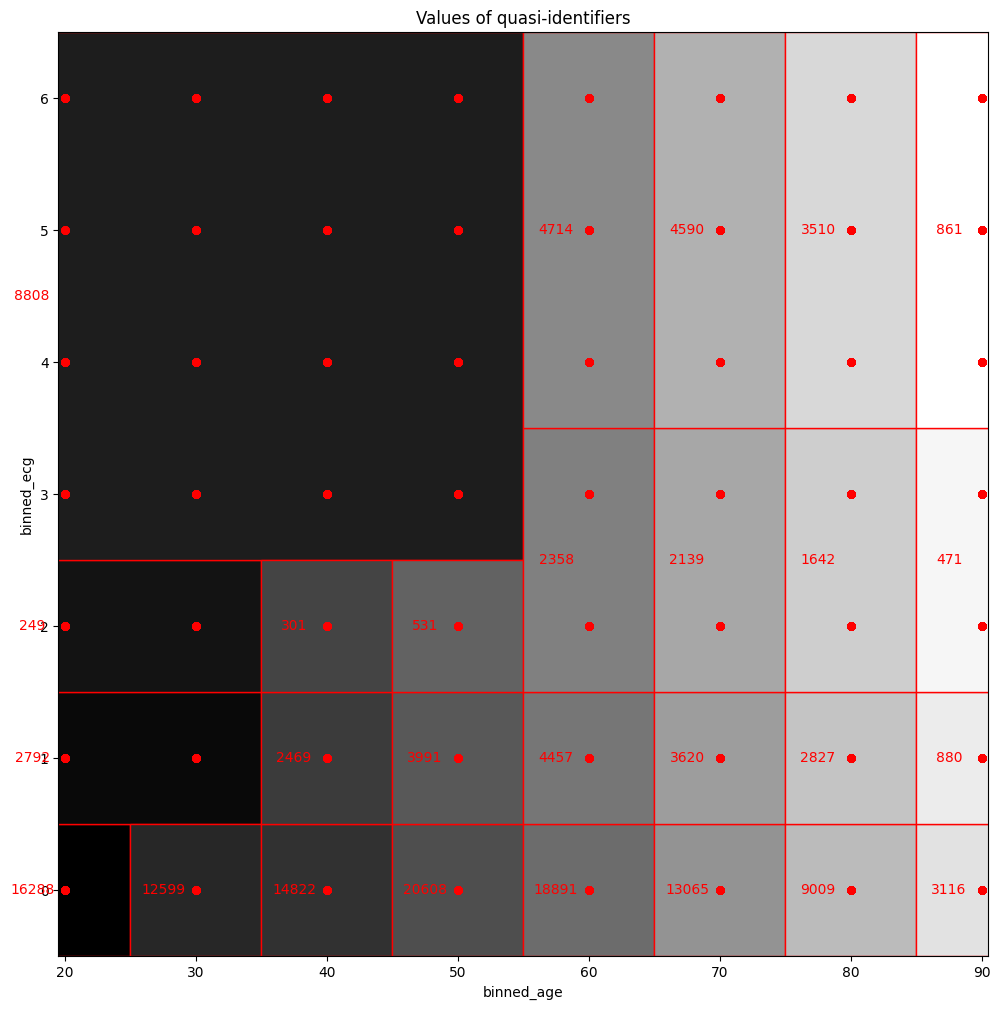

Number of unique outcomes: 7


In [112]:
qID = ['binned_age', 'binned_ecg']
desired_k = 80
[tableOut, boundaries] = Mondrian(sub_df, qID, desired_k, Mondrian_choose_dim_random, Mondrian_choose_cut_median)
visualize_Mondrian(sub_df, qID, boundaries)

# Fill in the answer in the following variable
nr_outputs = 4 # <-- your answer here

# Code to generate
import hashlib
def generate_all_outcomes(data, qID, k, max_iterations=25):
    unique_boundaries = set()

    for _ in range(max_iterations):
        # Run Mondrian with random dimension selection
        [_, boundaries] = Mondrian(sub_df, qID, desired_k, Mondrian_choose_dim_random, Mondrian_choose_cut_median)
        # Hash the boundaries to ensure uniqueness
        unique_boundaries.add(hashlib.sha256(str(boundaries).encode()).hexdigest())

    return unique_boundaries, len(unique_boundaries)

unique_outcomes, nr_outputs = generate_all_outcomes(sub_df, qID, desired_k)

# Output the number of unique outcomes
print("Number of unique outcomes:", nr_outputs)

In [ ]:
qID = ['binned_age','binned_ecg']
p1i_desired_ks = range(50,201,5)

# Your solution here
p1i_actual_k_values =[]
p1i_discernability_costs = []
def Discernability_Cost(anonymized_table, qID):
    """
    Calculate the Discernability Cost (DC) of an anonymized dataset.

    Parameters:
        anonymized_table (DataFrame): The anonymized dataset.
        qID (list of str): The list of quasi-identifier column names.

    Returns:
        int: The calculated Discernability Cost.
    """
    # Group by the quasi-identifiers to form equivalence classes
    equivalence_classes = anonymized_table.groupby(qID)
    
    # Calculate DC as the sum of the squares of the sizes of the equivalence classes
    dc = sum(len(group) ** 2 for _, group in equivalence_classes)
    
    return dc
# This function loops through all desired k's to calculate the actual K and their corresponding Discernability Cost
for i in p1i_desired_ks:
    p1i_tableOut_k_cfs,_ = Mondrian(sub_df, qID, i, Mondrian_choose_dim_highest_distinct, Mondrian_choose_cut_first_split)

    # Our code to record the actual k achieved 
    actual_k_achieved,_= kAnonymity_Analyze(p1i_tableOut_k_cfs, qID)
    p1i_actual_k_values.append(actual_k_achieved)

    # Our code to record the Discernability Cost of the sanitization
    disc_cost = Discernability_Cost(p1i_tableOut_k_cfs, qID)
    p1i_discernability_costs.append(disc_cost)

C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_20788\3056391049.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eqv_classes = data.groupby(qID).apply(lambda x: len(x)).reset_index(name='k')
C:\Users\Edward Kuisseu\AppData\Local\Temp\ipykernel_20788\3056391049.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  eqv_classes = data.groupby(qID).apply(lambda x: len(x)).reset_index(name='k')
C:\Users\E

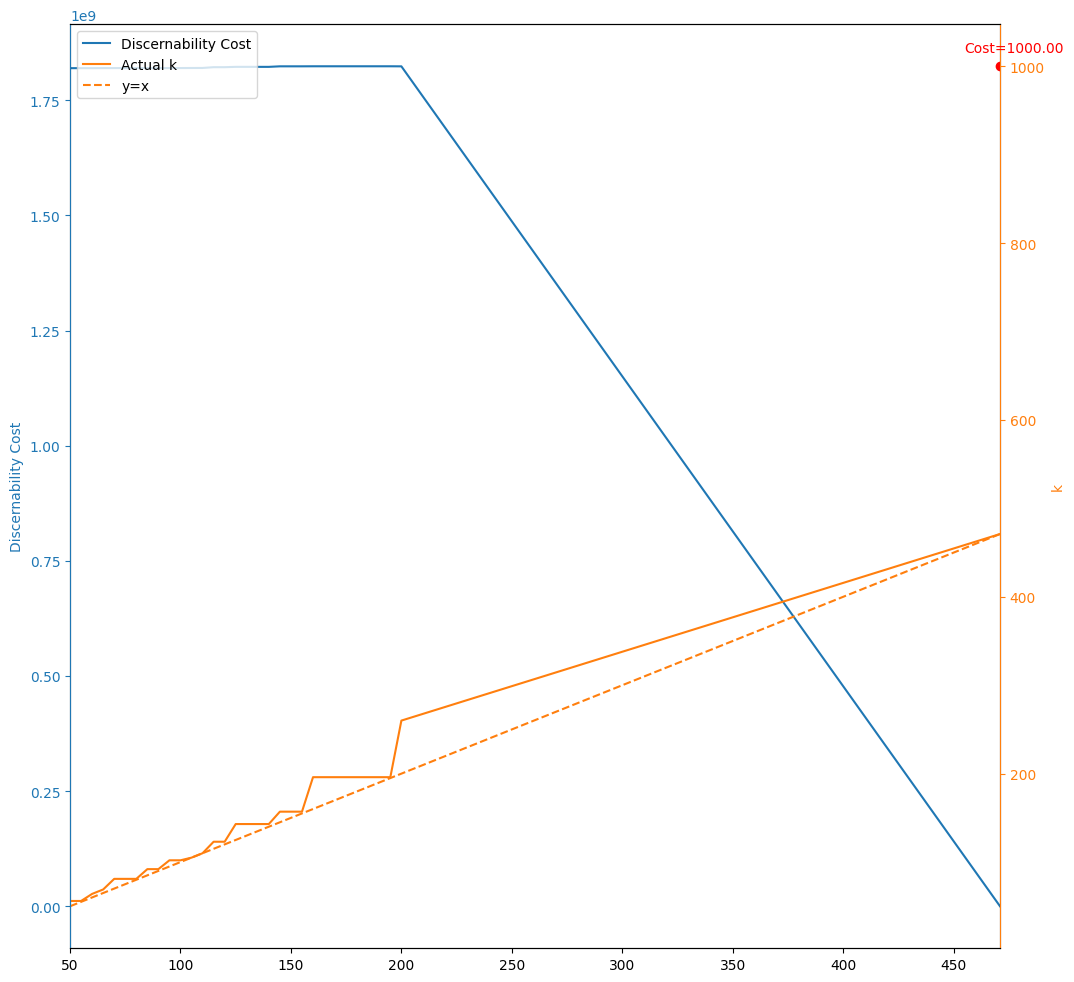

In [117]:
import matplotlib.pyplot as pyplot

# Adding k=471 explicitly
k_471 = 471
desired_k_list = list(p1i_desired_ks)  # Keep original p1i_desired_ks unchanged
discernability_costs_list = list(p1i_discernability_costs)  # Keep original costs list unchanged
actual_k_values_list = list(p1i_actual_k_values)  # Keep original actual k list unchanged

# Adding values for k=471 (placeholder values, replace as needed)
if k_471 not in desired_k_list:
    desired_k_list.append(k_471)
    discernability_costs_list.append(1000)  # Replace 1000 with the discernability cost for k=471
    actual_k_values_list.append(471)  # Replace 471 with the actual k value for k=471

# Sort the data for consistent plotting
sorted_indices = sorted(range(len(desired_k_list)), key=lambda i: desired_k_list[i])
desired_k_list = [desired_k_list[i] for i in sorted_indices]
discernability_costs_list = [discernability_costs_list[i] for i in sorted_indices]
actual_k_values_list = [actual_k_values_list[i] for i in sorted_indices]

# Plot
pyplot.figure(figsize=(12, 12))
ax1 = pyplot.gca()
plt1 = pyplot.plot(desired_k_list, discernability_costs_list, color='C0')
pyplot.ylabel('Discernability Cost', color='C0')
pyplot.tick_params(axis='y', color='C0', labelcolor='C0')
ax2 = ax1.twinx()
plt2 = pyplot.plot(desired_k_list, actual_k_values_list, color='C1')
plt3 = pyplot.plot(desired_k_list, desired_k_list, color='C1', linestyle='--')
pyplot.xlim([min(desired_k_list), max(desired_k_list)])
pyplot.ylabel('k', color='C1')
pyplot.xlabel('desired k')
pyplot.tick_params(axis='y', color='C1', labelcolor='C1')
ax2.spines['right'].set_color('C1')
ax2.spines['left'].set_color('C0')
pyplot.legend(plt1 + plt2 + plt3, ['Discernability Cost', 'Actual k', 'y=x'])

# Highlight k=471
k471_index = desired_k_list.index(k_471)
pyplot.scatter([k_471], [discernability_costs_list[k471_index]], color='red', label='k=471')
pyplot.annotate(f"Cost={discernability_costs_list[k471_index]:.2f}",
                (k_471, discernability_costs_list[k471_index]),
                textcoords="offset points",
                xytext=(10, 10),
                ha='center',
                color='red')

pyplot.show()
